La prima parte del codice è quasi identica a quella nella prima parte dell'assignment. Se si vogliono unire le due parti nello stesso codice, ci sono alcune piccole modifiche da fare:
- aggiunta di alcuni import (cancellare il comando pip)
- piccola modifica nell'ultima parte della definizione della training function (comunque perfettamente funzionante anche per quanto riguarda la prima parte dell'assignment)

Oltre a ciò, è necessario aggiungere tutta la parte successiva al markdown contenente la spiegazione della seconda parte dell'assignment.

In [ ]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

In [ ]:
import numpy as np
from pathlib import Path
from PIL import Image, ImageOps, ImageEnhance
from typing import List, Tuple
import copy
import cv2
import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR, MultiStepLR, ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau

!pip install torchsummary
from torchsummary import summary
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.4.0
12.3
True


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split # used for splitting the dataset in train and test
        self.paths, self.labels = self.read_file() #reading the labels and images

        self.transform = transform 

    def __len__(self) -> int: #get the number of elements in the dataset
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]: 
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    # legge un file di testo che contiene i percorsi delle immagini e le etichette associate
    # restituisce due liste: una con percorsi delle immagini e una con le etichette
    def read_file(self) -> Tuple[List[str], List[int]]: #outputs a tuple
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ") #rimuove il carattere di nuova linea, e poi divide in 3 parti con virgola come separatore 
                paths.append(path), labels.append(int(label)) #salva solo percorsi ed etichette

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

In [6]:
mean = [0.5306, 0.3964, 0.2564]
std = [0.2293, 0.2060, 0.1746]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

train_dataset = GroceryStoreDataset(split="train", transform=transform)
test_dataset = GroceryStoreDataset(split="test", transform=transform)
val_dataset = GroceryStoreDataset(split="val", transform=transform)

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.

In [54]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [55]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 32
num_epochs = 30
patience = 7

In [11]:
# Training function
def train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    early_stop_counter = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0
        epoch_val_loss = 0.0
        epoch_val_acc = 0.0

        # Training phase
        model.train() 
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()   
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                _, preds = torch.max(outputs, 1)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(val_loader.dataset)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | '
              f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc.item())
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc.item())

        if epoch_val_loss <= best_loss:
            best_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(best_loss)
        else:
            scheduler.step()

    print(f'Minimum val loss: {best_loss:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies


In [14]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

Epoch [1/30], Train Loss: 1.5396 Acc: 0.6545 | Val Loss: 0.9794 Acc: 0.7568
Epoch [2/30], Train Loss: 0.2360 Acc: 0.9792 | Val Loss: 0.7365 Acc: 0.8176
Epoch [3/30], Train Loss: 0.0785 Acc: 0.9951 | Val Loss: 0.6128 Acc: 0.8682
Epoch [4/30], Train Loss: 0.0338 Acc: 1.0000 | Val Loss: 0.5895 Acc: 0.8311
Epoch [5/30], Train Loss: 0.0195 Acc: 0.9996 | Val Loss: 0.5194 Acc: 0.8750
Epoch [6/30], Train Loss: 0.0129 Acc: 1.0000 | Val Loss: 0.5336 Acc: 0.8716
Epoch [7/30], Train Loss: 0.0105 Acc: 1.0000 | Val Loss: 0.5065 Acc: 0.8750
Epoch [8/30], Train Loss: 0.0078 Acc: 1.0000 | Val Loss: 0.4871 Acc: 0.8750
Epoch [9/30], Train Loss: 0.0087 Acc: 1.0000 | Val Loss: 0.5021 Acc: 0.8682
Epoch [10/30], Train Loss: 0.0077 Acc: 1.0000 | Val Loss: 0.4892 Acc: 0.8716
Epoch [11/30], Train Loss: 0.0078 Acc: 0.9996 | Val Loss: 0.4872 Acc: 0.8818
Epoch [12/30], Train Loss: 0.0068 Acc: 1.0000 | Val Loss: 0.4704 Acc: 0.8818
Epoch [13/30], Train Loss: 0.0077 Acc: 1.0000 | Val Loss: 0.4775 Acc: 0.8784
Epoch [1

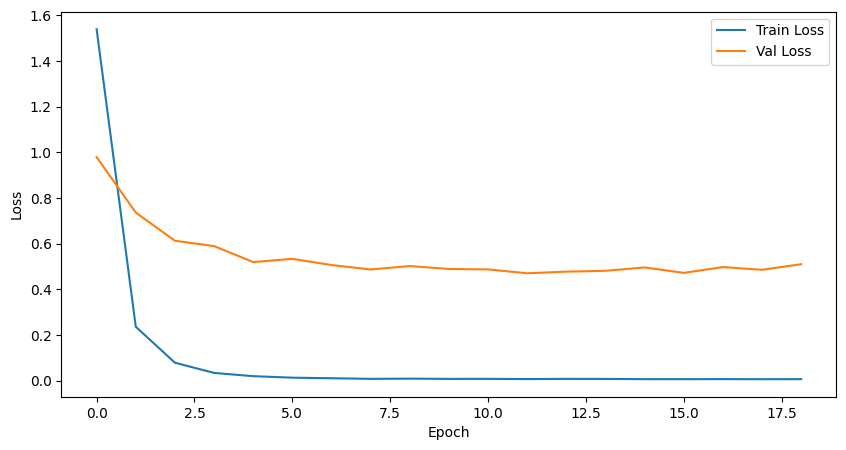

In [42]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler)

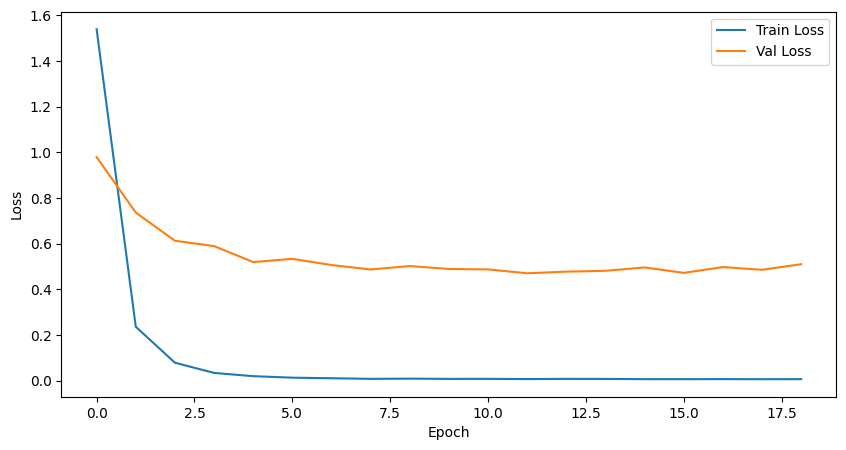

In [44]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

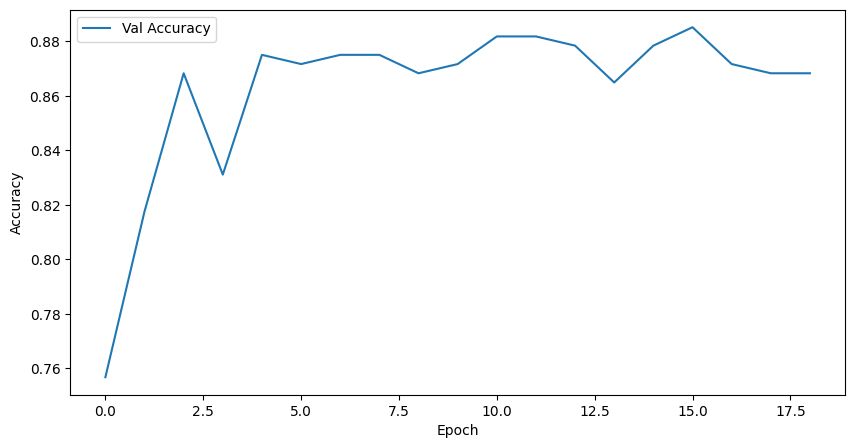

In [45]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

### EXPERIMENT 1 - EXPLOITATION OF CYCLICAL LEARNING RATES

> Training with cyclical learning rates instead of fixed values achieves improved classification accuracy without a need to tune and often in fewer iterations.>

Source: [Smith - Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186)

The proposed scheduler, specifically, changes the learning rate according to the 1cycle policy, described in [Smith, Topin - Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates](http://arxiv.org/abs/1708.07120)

In [69]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [65]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

batch_size = 32
num_epochs = 30
patience = 7

# new learning rate scheduler
one_cycle_scheduler = OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=num_epochs)

In [66]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, one_cycle_scheduler)

Epoch [1/30], Train Loss: 2.3028 Acc: 0.4606 | Val Loss: 1.8951 Acc: 0.5236
Epoch [2/30], Train Loss: 0.8513 Acc: 0.8511 | Val Loss: 1.3504 Acc: 0.6554
Epoch [3/30], Train Loss: 0.3874 Acc: 0.9595 | Val Loss: 1.0187 Acc: 0.7500
Epoch [4/30], Train Loss: 0.1822 Acc: 0.9936 | Val Loss: 0.8575 Acc: 0.7736
Epoch [5/30], Train Loss: 0.0996 Acc: 0.9970 | Val Loss: 0.7662 Acc: 0.8007
Epoch [6/30], Train Loss: 0.0589 Acc: 1.0000 | Val Loss: 0.7200 Acc: 0.8041
Epoch [7/30], Train Loss: 0.0412 Acc: 1.0000 | Val Loss: 0.7086 Acc: 0.7872
Epoch [8/30], Train Loss: 0.0308 Acc: 1.0000 | Val Loss: 0.7105 Acc: 0.7939
Epoch [9/30], Train Loss: 0.0232 Acc: 1.0000 | Val Loss: 0.6711 Acc: 0.7905
Epoch [10/30], Train Loss: 0.0189 Acc: 1.0000 | Val Loss: 0.6557 Acc: 0.8108
Epoch [11/30], Train Loss: 0.0182 Acc: 1.0000 | Val Loss: 0.5919 Acc: 0.8176
Epoch [12/30], Train Loss: 0.0148 Acc: 1.0000 | Val Loss: 0.6500 Acc: 0.8041
Epoch [13/30], Train Loss: 0.0119 Acc: 1.0000 | Val Loss: 0.6313 Acc: 0.8176
Epoch [1

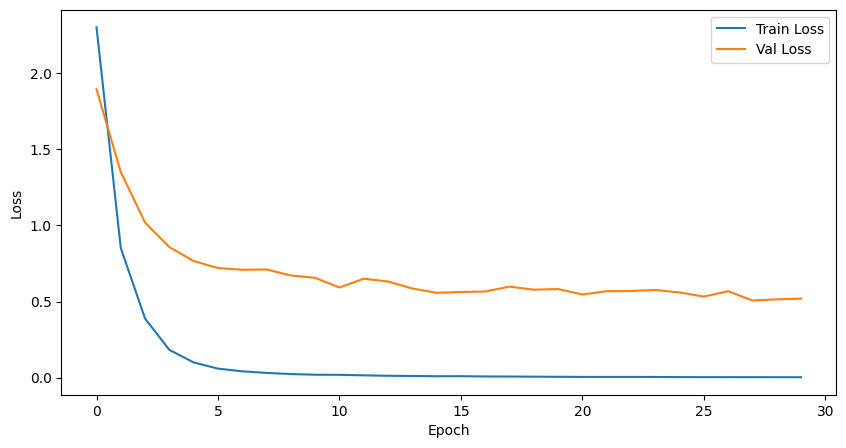

In [67]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

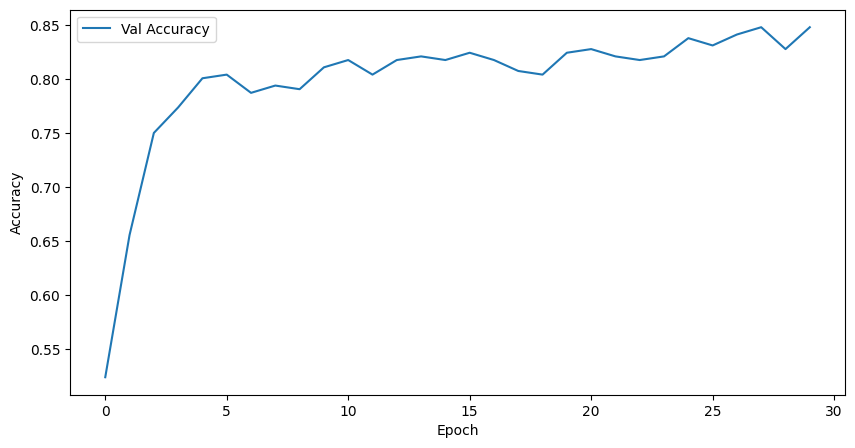

In [68]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### EXPERIMENT 2 - EXPLOITATION OF DIFFERENT SCHEDULERS

In this experiment, different schedulers are compared:
* [MultiStepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html)
* [ExponentialLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR)
* [CosineAnnealingLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR)
* [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau)

**MultiStepLR Scheduler**

In [71]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [72]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

batch_size = 32
num_epochs = 30
patience = 7

# scheduler
scheduler = MultiStepLR(optimizer, milestones=[30, 80], gamma=0.1)

In [74]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler)

Epoch [1/30], Train Loss: 1.8506 Acc: 0.5773 | Val Loss: 1.4045 Acc: 0.6318
Epoch [2/30], Train Loss: 0.3930 Acc: 0.9504 | Val Loss: 0.9547 Acc: 0.7635
Epoch [3/30], Train Loss: 0.1118 Acc: 0.9958 | Val Loss: 0.7737 Acc: 0.7872
Epoch [4/30], Train Loss: 0.0473 Acc: 0.9985 | Val Loss: 0.7015 Acc: 0.8074
Epoch [5/30], Train Loss: 0.0246 Acc: 1.0000 | Val Loss: 0.6775 Acc: 0.8277
Epoch [6/30], Train Loss: 0.0163 Acc: 1.0000 | Val Loss: 0.6698 Acc: 0.8209
Epoch [7/30], Train Loss: 0.0121 Acc: 1.0000 | Val Loss: 0.6452 Acc: 0.8108
Epoch [8/30], Train Loss: 0.0104 Acc: 1.0000 | Val Loss: 0.6388 Acc: 0.8108
Epoch [9/30], Train Loss: 0.0088 Acc: 1.0000 | Val Loss: 0.6357 Acc: 0.8277
Epoch [10/30], Train Loss: 0.0074 Acc: 1.0000 | Val Loss: 0.6101 Acc: 0.8209
Epoch [11/30], Train Loss: 0.0059 Acc: 1.0000 | Val Loss: 0.5976 Acc: 0.8209
Epoch [12/30], Train Loss: 0.0084 Acc: 0.9992 | Val Loss: 0.5991 Acc: 0.8412
Epoch [13/30], Train Loss: 0.0101 Acc: 0.9992 | Val Loss: 0.6840 Acc: 0.7973
Epoch [1

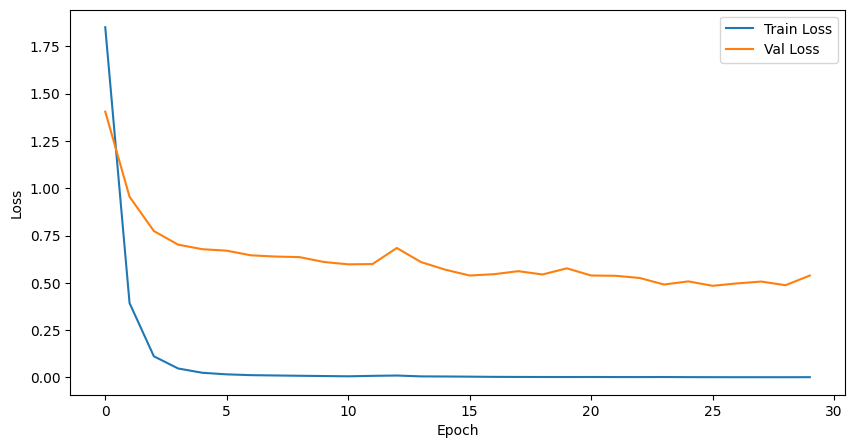

In [76]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

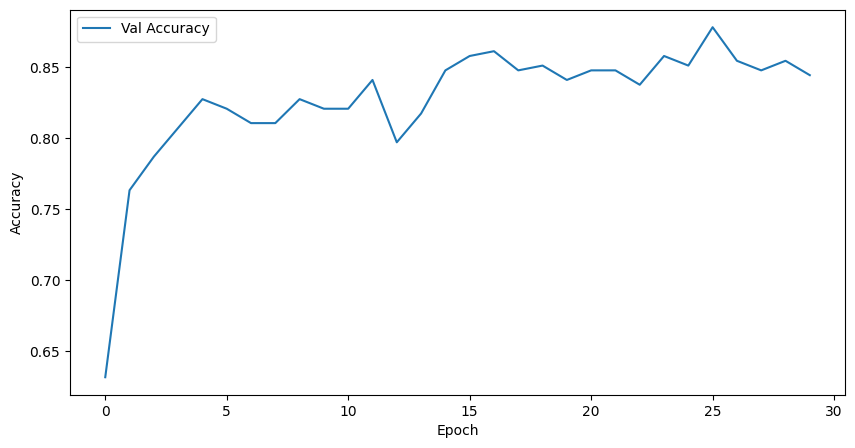

In [77]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**ExponentialLR scheduler**

In [78]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [79]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

batch_size = 32
num_epochs = 30
patience = 7

# scheduler
scheduler = ExponentialLR(optimizer, gamma=0.95)

In [81]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler)

Epoch [1/30], Train Loss: 1.9012 Acc: 0.5523 | Val Loss: 1.3298 Acc: 0.7061
Epoch [2/30], Train Loss: 0.4030 Acc: 0.9523 | Val Loss: 0.8596 Acc: 0.8074
Epoch [3/30], Train Loss: 0.1283 Acc: 0.9951 | Val Loss: 0.6930 Acc: 0.8209
Epoch [4/30], Train Loss: 0.0543 Acc: 0.9992 | Val Loss: 0.6365 Acc: 0.8378
Epoch [5/30], Train Loss: 0.0317 Acc: 1.0000 | Val Loss: 0.6054 Acc: 0.8412
Epoch [6/30], Train Loss: 0.0206 Acc: 1.0000 | Val Loss: 0.5936 Acc: 0.8311
Epoch [7/30], Train Loss: 0.0173 Acc: 0.9996 | Val Loss: 0.5601 Acc: 0.8378
Epoch [8/30], Train Loss: 0.0128 Acc: 1.0000 | Val Loss: 0.5331 Acc: 0.8480
Epoch [9/30], Train Loss: 0.0114 Acc: 1.0000 | Val Loss: 0.5363 Acc: 0.8514
Epoch [10/30], Train Loss: 0.0110 Acc: 1.0000 | Val Loss: 0.5141 Acc: 0.8446
Epoch [11/30], Train Loss: 0.0085 Acc: 1.0000 | Val Loss: 0.5167 Acc: 0.8480
Epoch [12/30], Train Loss: 0.0076 Acc: 1.0000 | Val Loss: 0.4966 Acc: 0.8547
Epoch [13/30], Train Loss: 0.0068 Acc: 1.0000 | Val Loss: 0.5224 Acc: 0.8378
Epoch [1

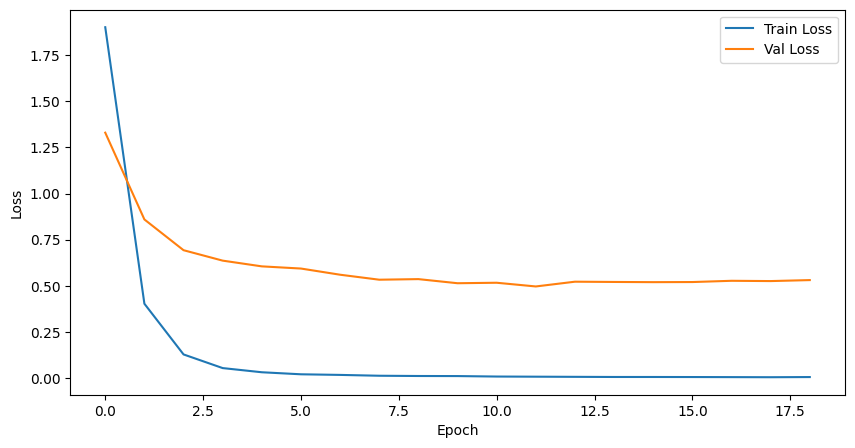

In [82]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

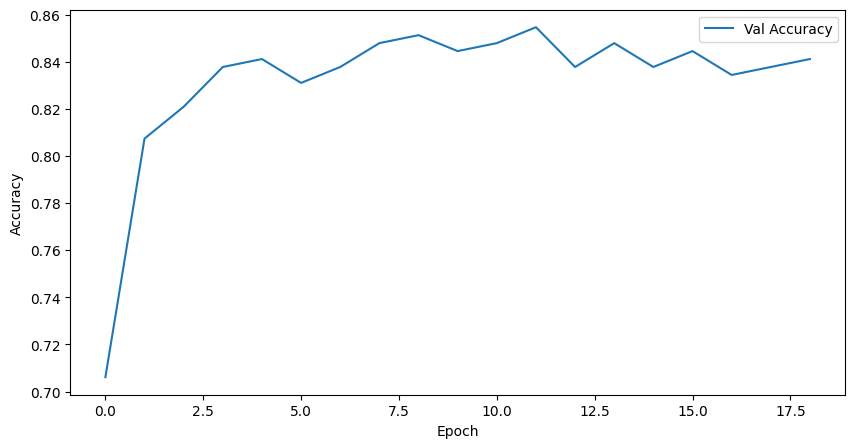

In [83]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**CosineAnnealingLR scheduler**

In [84]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [85]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

batch_size = 32
num_epochs = 30
patience = 7

# scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=50)

In [86]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler)

Epoch [1/30], Train Loss: 1.8164 Acc: 0.5758 | Val Loss: 1.3620 Acc: 0.6284
Epoch [2/30], Train Loss: 0.3754 Acc: 0.9576 | Val Loss: 0.8228 Acc: 0.8108
Epoch [3/30], Train Loss: 0.1048 Acc: 0.9955 | Val Loss: 0.6926 Acc: 0.8345
Epoch [4/30], Train Loss: 0.0441 Acc: 0.9996 | Val Loss: 0.6033 Acc: 0.8547
Epoch [5/30], Train Loss: 0.0256 Acc: 1.0000 | Val Loss: 0.5977 Acc: 0.8412
Epoch [6/30], Train Loss: 0.0165 Acc: 1.0000 | Val Loss: 0.5739 Acc: 0.8412
Epoch [7/30], Train Loss: 0.0125 Acc: 1.0000 | Val Loss: 0.5572 Acc: 0.8412
Epoch [8/30], Train Loss: 0.0105 Acc: 1.0000 | Val Loss: 0.5651 Acc: 0.8446
Epoch [9/30], Train Loss: 0.0119 Acc: 0.9992 | Val Loss: 0.6423 Acc: 0.8108
Epoch [10/30], Train Loss: 0.0088 Acc: 0.9996 | Val Loss: 0.5658 Acc: 0.8074
Epoch [11/30], Train Loss: 0.0068 Acc: 0.9996 | Val Loss: 0.5706 Acc: 0.8345
Epoch [12/30], Train Loss: 0.0058 Acc: 1.0000 | Val Loss: 0.5600 Acc: 0.8480
Epoch [13/30], Train Loss: 0.0048 Acc: 1.0000 | Val Loss: 0.5128 Acc: 0.8311
Epoch [1

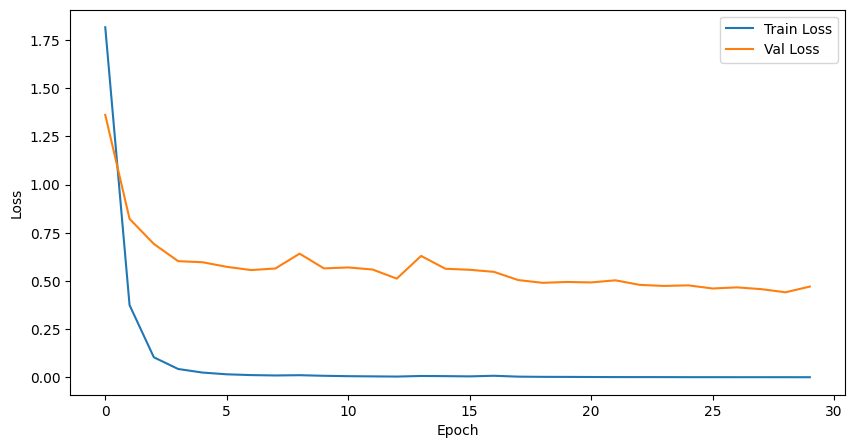

In [87]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

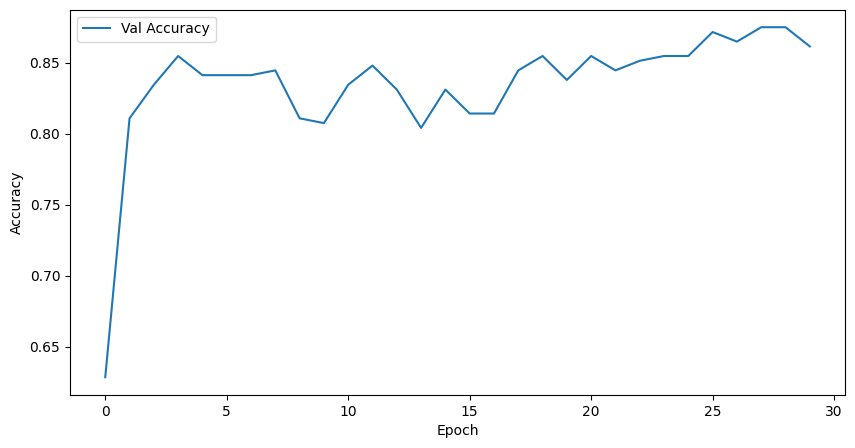

In [88]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**ReduceLROnPlateau scheduler**

In [106]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [107]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

batch_size = 32
num_epochs = 30
patience = 7

# scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

In [108]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler)

Epoch [1/30], Train Loss: 1.9130 Acc: 0.5553 | Val Loss: 1.4996 Acc: 0.6014
Epoch [2/30], Train Loss: 0.4035 Acc: 0.9470 | Val Loss: 0.9592 Acc: 0.7568
Epoch [3/30], Train Loss: 0.1186 Acc: 0.9943 | Val Loss: 0.7798 Acc: 0.8277
Epoch [4/30], Train Loss: 0.0474 Acc: 0.9996 | Val Loss: 0.7121 Acc: 0.8142
Epoch [5/30], Train Loss: 0.0280 Acc: 1.0000 | Val Loss: 0.6780 Acc: 0.8108
Epoch [6/30], Train Loss: 0.0213 Acc: 1.0000 | Val Loss: 0.6658 Acc: 0.8243
Epoch [7/30], Train Loss: 0.0188 Acc: 1.0000 | Val Loss: 0.6742 Acc: 0.8176
Epoch [8/30], Train Loss: 0.0186 Acc: 1.0000 | Val Loss: 0.6506 Acc: 0.8378
Epoch [9/30], Train Loss: 0.0181 Acc: 1.0000 | Val Loss: 0.6599 Acc: 0.8277
Epoch [10/30], Train Loss: 0.0167 Acc: 1.0000 | Val Loss: 0.6457 Acc: 0.8277
Epoch [11/30], Train Loss: 0.0164 Acc: 1.0000 | Val Loss: 0.6398 Acc: 0.8412
Epoch [12/30], Train Loss: 0.0170 Acc: 1.0000 | Val Loss: 0.6449 Acc: 0.8243
Epoch [13/30], Train Loss: 0.0173 Acc: 1.0000 | Val Loss: 0.6646 Acc: 0.8277
Epoch [1

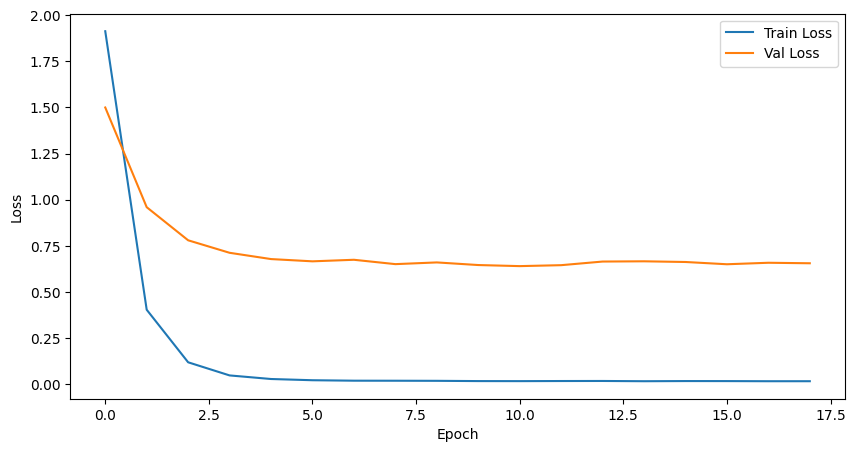

In [109]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

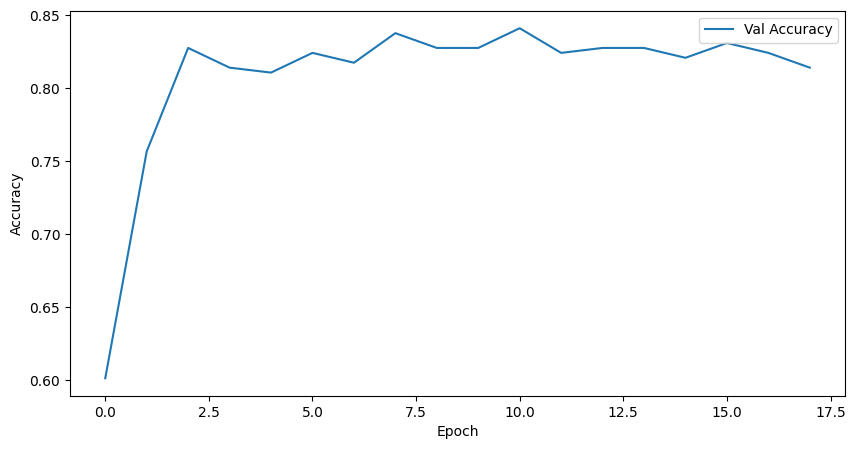

In [110]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### EXPERIMENT 3 - EXPLOITATION OF DIFFERENT OPTIMIZERS

In this experiment, different optimizers are exploited in the attempt of achieving better performances in terms of accuracy on the validation split:
* [SDG optimizer with momentum](http://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
* [Adagrad](http://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html)
* [NAG](http://mitliagkas.github.io/ift6085-2019/ift-6085-lecture-6-notes.pdf)
* [RAdam](https://pytorch.org/docs/stable/generated/torch.optim.RAdam)

**SDG optimizer with momentum**

In [87]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [88]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 32
num_epochs = 30
patience = 7

In [89]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, one_cycle_scheduler)

Epoch [1/30], Train Loss: 2.4999 Acc: 0.4011 | Val Loss: 2.0359 Acc: 0.4730
Epoch [2/30], Train Loss: 1.1031 Acc: 0.7682 | Val Loss: 1.3509 Acc: 0.6723
Epoch [3/30], Train Loss: 0.5526 Acc: 0.9246 | Val Loss: 1.0631 Acc: 0.7568
Epoch [4/30], Train Loss: 0.3283 Acc: 0.9670 | Val Loss: 0.8736 Acc: 0.7736
Epoch [5/30], Train Loss: 0.2036 Acc: 0.9875 | Val Loss: 0.7743 Acc: 0.8176
Epoch [6/30], Train Loss: 0.1430 Acc: 0.9917 | Val Loss: 0.7274 Acc: 0.7770
Epoch [7/30], Train Loss: 0.0998 Acc: 0.9966 | Val Loss: 0.6613 Acc: 0.8209
Epoch [8/30], Train Loss: 0.0757 Acc: 0.9981 | Val Loss: 0.6314 Acc: 0.8209
Epoch [9/30], Train Loss: 0.0629 Acc: 0.9985 | Val Loss: 0.6246 Acc: 0.8581
Epoch [10/30], Train Loss: 0.0513 Acc: 0.9992 | Val Loss: 0.6139 Acc: 0.8311
Epoch [11/30], Train Loss: 0.0415 Acc: 1.0000 | Val Loss: 0.5846 Acc: 0.8412
Epoch [12/30], Train Loss: 0.0377 Acc: 1.0000 | Val Loss: 0.5606 Acc: 0.8378
Epoch [13/30], Train Loss: 0.0357 Acc: 1.0000 | Val Loss: 0.5689 Acc: 0.8311
Epoch [1

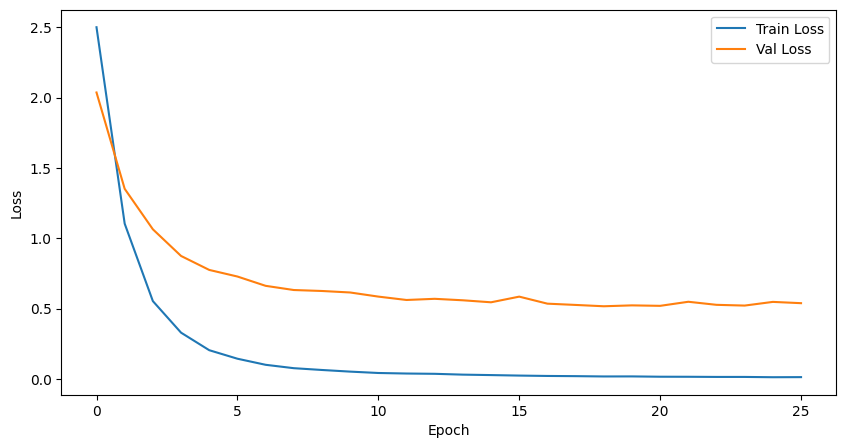

In [90]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

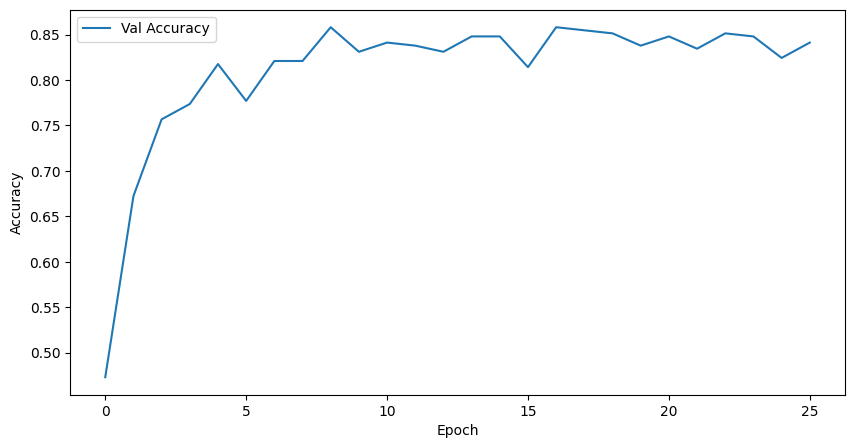

In [91]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Adagrad optimizer**

In [92]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [93]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=0.0001)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 32
num_epochs = 30
patience = 7

In [94]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, one_cycle_scheduler)

Epoch [1/30], Train Loss: 0.8132 Acc: 0.8167 | Val Loss: 0.7970 Acc: 0.7872
Epoch [2/30], Train Loss: 0.0917 Acc: 0.9955 | Val Loss: 0.6028 Acc: 0.8514
Epoch [3/30], Train Loss: 0.0422 Acc: 0.9992 | Val Loss: 0.6924 Acc: 0.8345
Epoch [4/30], Train Loss: 0.0247 Acc: 0.9996 | Val Loss: 0.5631 Acc: 0.8378
Epoch [5/30], Train Loss: 0.0191 Acc: 1.0000 | Val Loss: 0.5370 Acc: 0.8412
Epoch [6/30], Train Loss: 0.0155 Acc: 1.0000 | Val Loss: 0.5108 Acc: 0.8615
Epoch [7/30], Train Loss: 0.0130 Acc: 1.0000 | Val Loss: 0.5314 Acc: 0.8446
Epoch [8/30], Train Loss: 0.0105 Acc: 1.0000 | Val Loss: 0.5064 Acc: 0.8649
Epoch [9/30], Train Loss: 0.0090 Acc: 1.0000 | Val Loss: 0.5385 Acc: 0.8176
Epoch [10/30], Train Loss: 0.0088 Acc: 1.0000 | Val Loss: 0.5041 Acc: 0.8547
Epoch [11/30], Train Loss: 0.0068 Acc: 1.0000 | Val Loss: 0.5078 Acc: 0.8514
Epoch [12/30], Train Loss: 0.0066 Acc: 1.0000 | Val Loss: 0.4938 Acc: 0.8547
Epoch [13/30], Train Loss: 0.0065 Acc: 1.0000 | Val Loss: 0.5029 Acc: 0.8412
Epoch [1

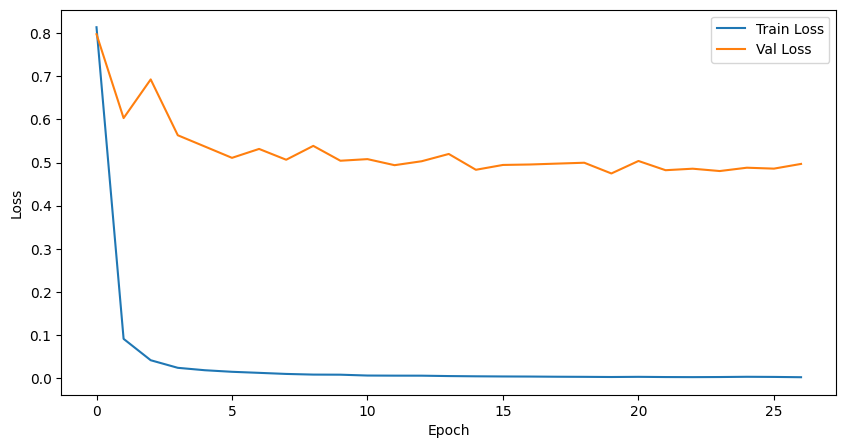

In [95]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

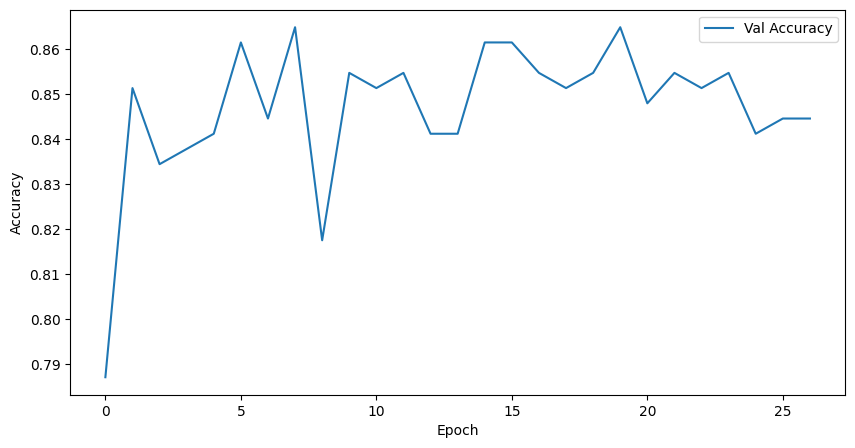

In [96]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**NAG optimizer**

In [104]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [105]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True, weight_decay=0.0001)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 32
num_epochs = 30
patience = 7

In [106]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, one_cycle_scheduler)

Epoch [1/30], Train Loss: 2.4499 Acc: 0.4129 | Val Loss: 1.9339 Acc: 0.5372
Epoch [2/30], Train Loss: 1.0843 Acc: 0.7644 | Val Loss: 1.3262 Acc: 0.6351
Epoch [3/30], Train Loss: 0.5734 Acc: 0.9110 | Val Loss: 0.9861 Acc: 0.7568
Epoch [4/30], Train Loss: 0.3309 Acc: 0.9636 | Val Loss: 0.8246 Acc: 0.7939
Epoch [5/30], Train Loss: 0.2062 Acc: 0.9883 | Val Loss: 0.7654 Acc: 0.7905
Epoch [6/30], Train Loss: 0.1430 Acc: 0.9943 | Val Loss: 0.6878 Acc: 0.7973
Epoch [7/30], Train Loss: 0.1056 Acc: 0.9955 | Val Loss: 0.6585 Acc: 0.7973
Epoch [8/30], Train Loss: 0.0802 Acc: 0.9962 | Val Loss: 0.6264 Acc: 0.8041
Epoch [9/30], Train Loss: 0.0594 Acc: 0.9992 | Val Loss: 0.6005 Acc: 0.8345
Epoch [10/30], Train Loss: 0.0501 Acc: 0.9989 | Val Loss: 0.5918 Acc: 0.8108
Epoch [11/30], Train Loss: 0.0431 Acc: 1.0000 | Val Loss: 0.5592 Acc: 0.8277
Epoch [12/30], Train Loss: 0.0349 Acc: 1.0000 | Val Loss: 0.5507 Acc: 0.8277
Epoch [13/30], Train Loss: 0.0319 Acc: 0.9996 | Val Loss: 0.5529 Acc: 0.8311
Epoch [1

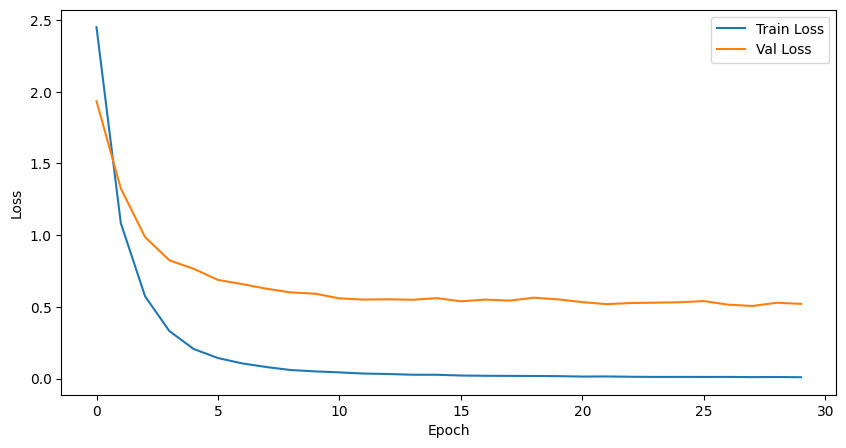

In [107]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

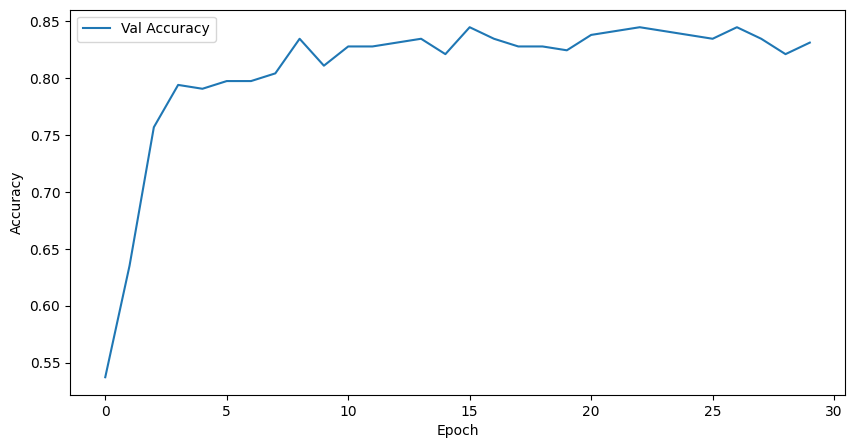

In [108]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**RAdam optimizer**

In [115]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [117]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.RAdam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 32
num_epochs = 30
patience = 7

In [118]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, one_cycle_scheduler)

Epoch [1/30], Train Loss: 3.4820 Acc: 0.1561 | Val Loss: 2.8282 Acc: 0.3412
Epoch [2/30], Train Loss: 1.9051 Acc: 0.6034 | Val Loss: 1.9312 Acc: 0.5135
Epoch [3/30], Train Loss: 0.9887 Acc: 0.8405 | Val Loss: 1.4010 Acc: 0.6554
Epoch [4/30], Train Loss: 0.5082 Acc: 0.9390 | Val Loss: 1.0859 Acc: 0.7770
Epoch [5/30], Train Loss: 0.2662 Acc: 0.9826 | Val Loss: 0.8753 Acc: 0.8074
Epoch [6/30], Train Loss: 0.1446 Acc: 0.9981 | Val Loss: 0.7653 Acc: 0.8074
Epoch [7/30], Train Loss: 0.0833 Acc: 0.9985 | Val Loss: 0.7186 Acc: 0.8108
Epoch [8/30], Train Loss: 0.0545 Acc: 0.9996 | Val Loss: 0.6734 Acc: 0.8311
Epoch [9/30], Train Loss: 0.0368 Acc: 1.0000 | Val Loss: 0.6415 Acc: 0.8514
Epoch [10/30], Train Loss: 0.0284 Acc: 1.0000 | Val Loss: 0.6388 Acc: 0.8311
Epoch [11/30], Train Loss: 0.0220 Acc: 1.0000 | Val Loss: 0.6215 Acc: 0.8311
Epoch [12/30], Train Loss: 0.0173 Acc: 0.9996 | Val Loss: 0.6041 Acc: 0.8446
Epoch [13/30], Train Loss: 0.0138 Acc: 1.0000 | Val Loss: 0.5879 Acc: 0.8514
Epoch [1

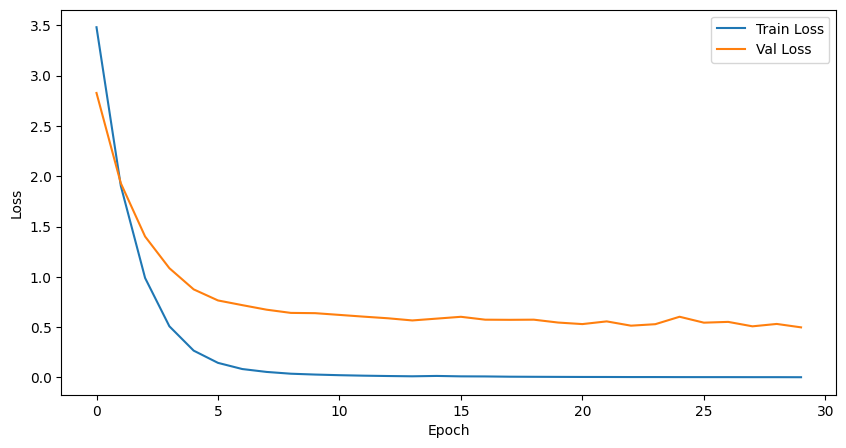

In [119]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

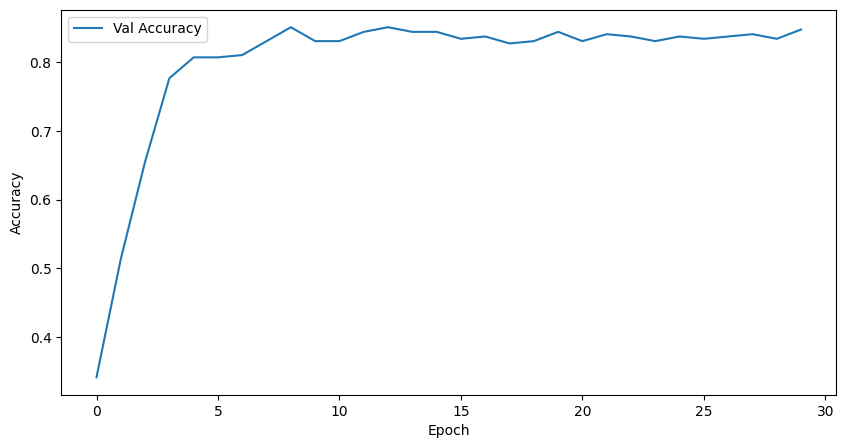

In [120]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### EXPERIMENT 4 - OPTIMIZATION OF WEIGHT DECAY HYPERPARAMETER

In this experiment, different choices for weight decay are compared; the original Adam Optimizer setup is exploited.

In [15]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [16]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.1)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 32
num_epochs = 30
patience = 7

In [20]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler)

Epoch [1/30], Train Loss: 1.5086 Acc: 0.6568 | Val Loss: 1.0777 Acc: 0.7264
Epoch [2/30], Train Loss: 0.2403 Acc: 0.9758 | Val Loss: 0.8084 Acc: 0.7905
Epoch [3/30], Train Loss: 0.0719 Acc: 0.9947 | Val Loss: 0.7484 Acc: 0.8007
Epoch [4/30], Train Loss: 0.0319 Acc: 0.9996 | Val Loss: 0.6220 Acc: 0.8243
Epoch [5/30], Train Loss: 0.0191 Acc: 0.9996 | Val Loss: 0.6078 Acc: 0.8311
Epoch [6/30], Train Loss: 0.0171 Acc: 0.9996 | Val Loss: 0.5929 Acc: 0.8209
Epoch [7/30], Train Loss: 0.0129 Acc: 0.9996 | Val Loss: 0.6110 Acc: 0.8412
Epoch [8/30], Train Loss: 0.0111 Acc: 0.9996 | Val Loss: 0.6049 Acc: 0.8277
Epoch [9/30], Train Loss: 0.0087 Acc: 1.0000 | Val Loss: 0.6028 Acc: 0.8209
Epoch [10/30], Train Loss: 0.0084 Acc: 1.0000 | Val Loss: 0.5725 Acc: 0.8378
Epoch [11/30], Train Loss: 0.0072 Acc: 1.0000 | Val Loss: 0.5699 Acc: 0.8412
Epoch [12/30], Train Loss: 0.0073 Acc: 1.0000 | Val Loss: 0.5753 Acc: 0.8311
Epoch [13/30], Train Loss: 0.0066 Acc: 1.0000 | Val Loss: 0.5980 Acc: 0.8311
Epoch [1

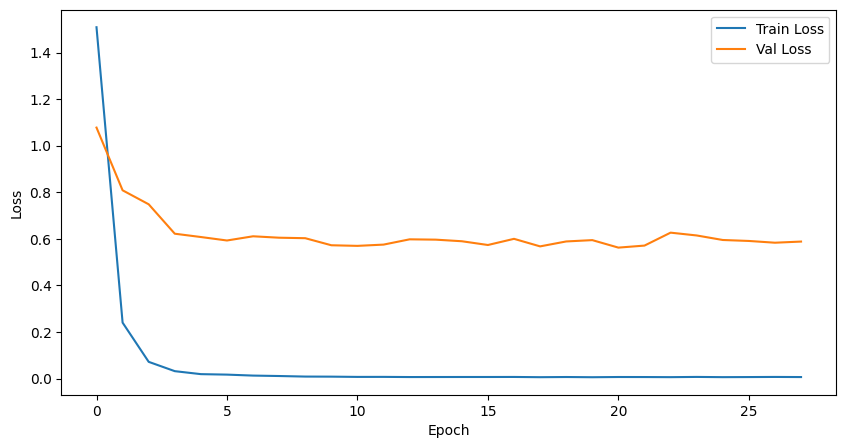

In [21]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

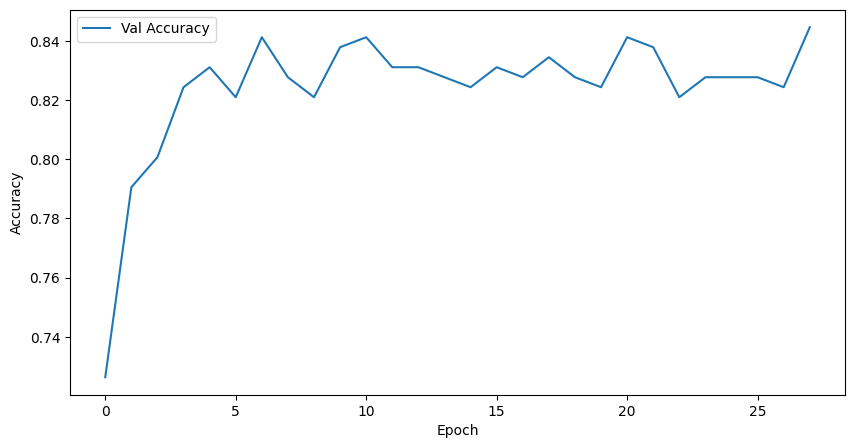

In [22]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [24]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 32
num_epochs = 30
patience = 7

In [25]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler)

Epoch [1/30], Train Loss: 1.4739 Acc: 0.6644 | Val Loss: 1.1020 Acc: 0.7534
Epoch [2/30], Train Loss: 0.2297 Acc: 0.9754 | Val Loss: 0.6868 Acc: 0.8446
Epoch [3/30], Train Loss: 0.0646 Acc: 0.9981 | Val Loss: 0.6506 Acc: 0.8142
Epoch [4/30], Train Loss: 0.0319 Acc: 0.9996 | Val Loss: 0.7422 Acc: 0.8041
Epoch [5/30], Train Loss: 0.0240 Acc: 0.9977 | Val Loss: 0.6461 Acc: 0.8108
Epoch [6/30], Train Loss: 0.0159 Acc: 1.0000 | Val Loss: 0.5919 Acc: 0.8345
Epoch [7/30], Train Loss: 0.0099 Acc: 1.0000 | Val Loss: 0.5443 Acc: 0.8378
Epoch [8/30], Train Loss: 0.0069 Acc: 1.0000 | Val Loss: 0.5368 Acc: 0.8514
Epoch [9/30], Train Loss: 0.0071 Acc: 1.0000 | Val Loss: 0.5479 Acc: 0.8345
Epoch [10/30], Train Loss: 0.0069 Acc: 1.0000 | Val Loss: 0.5460 Acc: 0.8412
Epoch [11/30], Train Loss: 0.0069 Acc: 1.0000 | Val Loss: 0.5400 Acc: 0.8277
Epoch [12/30], Train Loss: 0.0069 Acc: 1.0000 | Val Loss: 0.5580 Acc: 0.8345
Epoch [13/30], Train Loss: 0.0075 Acc: 1.0000 | Val Loss: 0.5274 Acc: 0.8446
Epoch [1

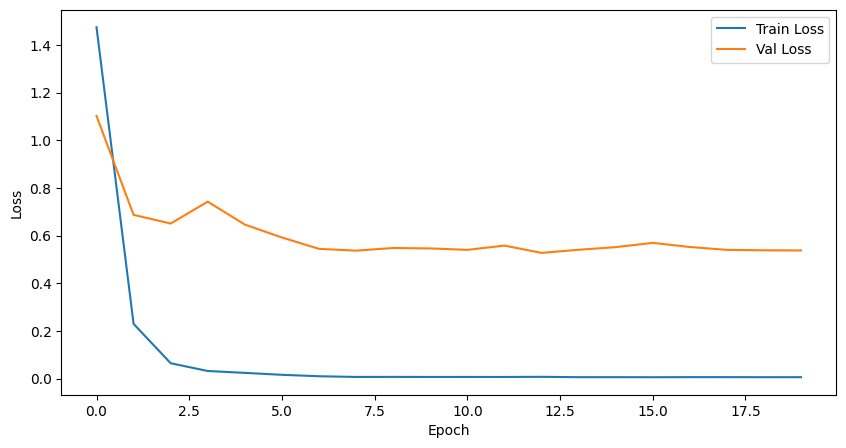

In [26]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

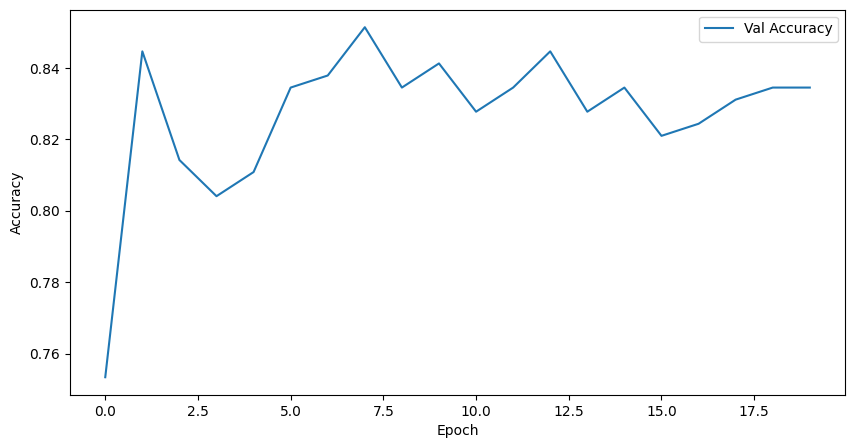

In [27]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [29]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.001)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 32
num_epochs = 30
patience = 7

In [30]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler)

Epoch [1/30], Train Loss: 1.4611 Acc: 0.6723 | Val Loss: 1.0217 Acc: 0.7466
Epoch [2/30], Train Loss: 0.2278 Acc: 0.9761 | Val Loss: 0.6868 Acc: 0.8176
Epoch [3/30], Train Loss: 0.0615 Acc: 0.9985 | Val Loss: 0.5586 Acc: 0.8615
Epoch [4/30], Train Loss: 0.0286 Acc: 1.0000 | Val Loss: 0.5216 Acc: 0.8581
Epoch [5/30], Train Loss: 0.0171 Acc: 1.0000 | Val Loss: 0.5143 Acc: 0.8716
Epoch [6/30], Train Loss: 0.0121 Acc: 1.0000 | Val Loss: 0.5306 Acc: 0.8547
Epoch [7/30], Train Loss: 0.0117 Acc: 0.9996 | Val Loss: 0.5186 Acc: 0.8446
Epoch [8/30], Train Loss: 0.0097 Acc: 1.0000 | Val Loss: 0.4936 Acc: 0.8649
Epoch [9/30], Train Loss: 0.0080 Acc: 1.0000 | Val Loss: 0.4814 Acc: 0.8784
Epoch [10/30], Train Loss: 0.0072 Acc: 1.0000 | Val Loss: 0.5120 Acc: 0.8581
Epoch [11/30], Train Loss: 0.0065 Acc: 1.0000 | Val Loss: 0.4926 Acc: 0.8649
Epoch [12/30], Train Loss: 0.0079 Acc: 0.9996 | Val Loss: 0.4984 Acc: 0.8615
Epoch [13/30], Train Loss: 0.0066 Acc: 1.0000 | Val Loss: 0.5015 Acc: 0.8547
Epoch [1

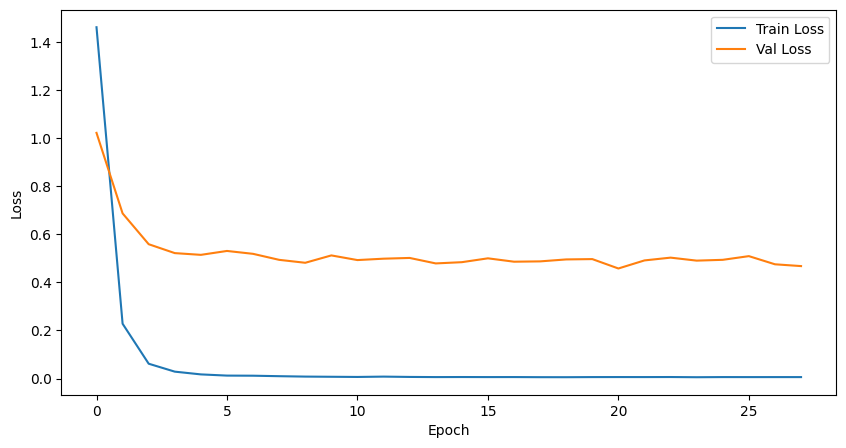

In [31]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

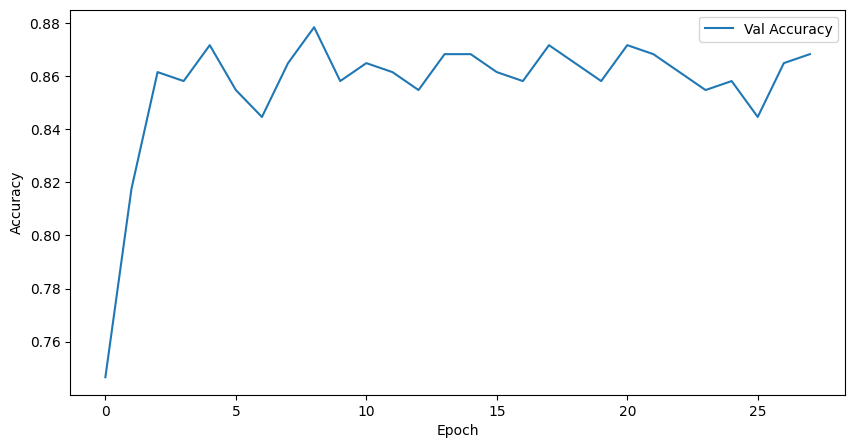

In [32]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [33]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [34]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00001)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 32
num_epochs = 30
patience = 7

In [35]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler)

Epoch [1/30], Train Loss: 1.4999 Acc: 0.6614 | Val Loss: 1.0289 Acc: 0.7500
Epoch [2/30], Train Loss: 0.2292 Acc: 0.9803 | Val Loss: 0.7076 Acc: 0.8243
Epoch [3/30], Train Loss: 0.0661 Acc: 0.9989 | Val Loss: 0.6376 Acc: 0.8345
Epoch [4/30], Train Loss: 0.0287 Acc: 0.9996 | Val Loss: 0.5657 Acc: 0.8345
Epoch [5/30], Train Loss: 0.0179 Acc: 0.9996 | Val Loss: 0.5713 Acc: 0.8378
Epoch [6/30], Train Loss: 0.0167 Acc: 0.9989 | Val Loss: 0.5596 Acc: 0.8514
Epoch [7/30], Train Loss: 0.0118 Acc: 1.0000 | Val Loss: 0.5349 Acc: 0.8547
Epoch [8/30], Train Loss: 0.0086 Acc: 1.0000 | Val Loss: 0.5306 Acc: 0.8514
Epoch [9/30], Train Loss: 0.0080 Acc: 1.0000 | Val Loss: 0.5264 Acc: 0.8514
Epoch [10/30], Train Loss: 0.0075 Acc: 1.0000 | Val Loss: 0.5223 Acc: 0.8547
Epoch [11/30], Train Loss: 0.0072 Acc: 1.0000 | Val Loss: 0.5169 Acc: 0.8615
Epoch [12/30], Train Loss: 0.0069 Acc: 1.0000 | Val Loss: 0.5286 Acc: 0.8446
Epoch [13/30], Train Loss: 0.0068 Acc: 1.0000 | Val Loss: 0.5007 Acc: 0.8649
Epoch [1

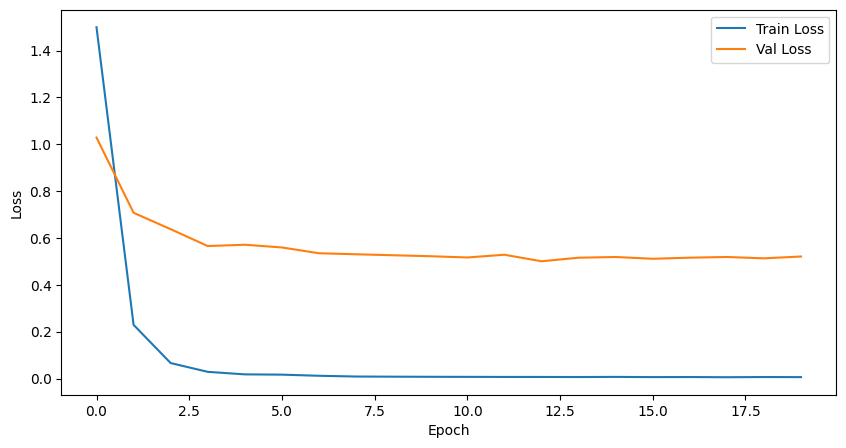

In [36]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

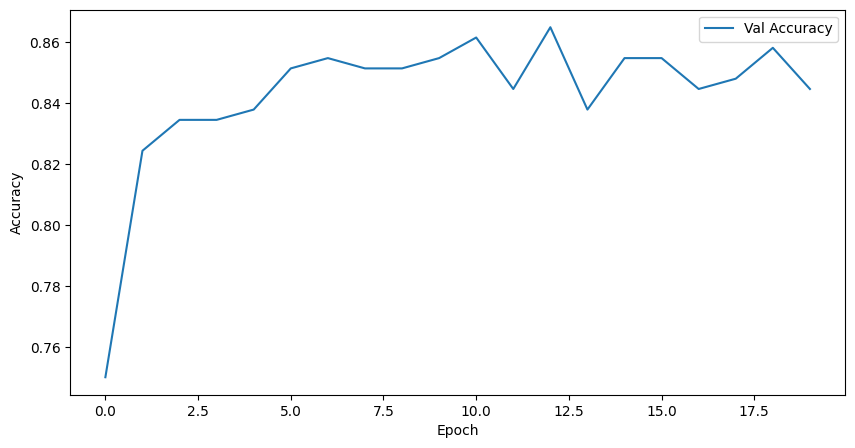

In [37]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### EXPERIMENT 5 - OPTIMIZATION OF BATCH SIZE

In this experiment, different choices for batch size are compared; the original setup is otherwise left as it is.

In [51]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [52]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 8
num_epochs = 30
patience = 7

In [53]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [54]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler)

Epoch [1/30], Train Loss: 1.3050 Acc: 0.6879 | Val Loss: 0.7744 Acc: 0.7736
Epoch [2/30], Train Loss: 0.2380 Acc: 0.9701 | Val Loss: 0.5650 Acc: 0.8311
Epoch [3/30], Train Loss: 0.0911 Acc: 0.9924 | Val Loss: 0.6666 Acc: 0.8345
Epoch [4/30], Train Loss: 0.0636 Acc: 0.9951 | Val Loss: 0.5343 Acc: 0.8446
Epoch [5/30], Train Loss: 0.0602 Acc: 0.9917 | Val Loss: 0.7505 Acc: 0.8007
Epoch [6/30], Train Loss: 0.0629 Acc: 0.9902 | Val Loss: 0.6951 Acc: 0.7838
Epoch [7/30], Train Loss: 0.0434 Acc: 0.9939 | Val Loss: 0.7040 Acc: 0.7973
Epoch [8/30], Train Loss: 0.0274 Acc: 0.9966 | Val Loss: 0.5683 Acc: 0.8209
Epoch [9/30], Train Loss: 0.0210 Acc: 0.9989 | Val Loss: 0.5351 Acc: 0.8176
Epoch [10/30], Train Loss: 0.0150 Acc: 0.9992 | Val Loss: 0.5158 Acc: 0.8345
Epoch [11/30], Train Loss: 0.0142 Acc: 0.9985 | Val Loss: 0.5312 Acc: 0.8209
Epoch [12/30], Train Loss: 0.0125 Acc: 0.9992 | Val Loss: 0.5403 Acc: 0.8378
Epoch [13/30], Train Loss: 0.0155 Acc: 0.9973 | Val Loss: 0.5754 Acc: 0.8108
Epoch [1

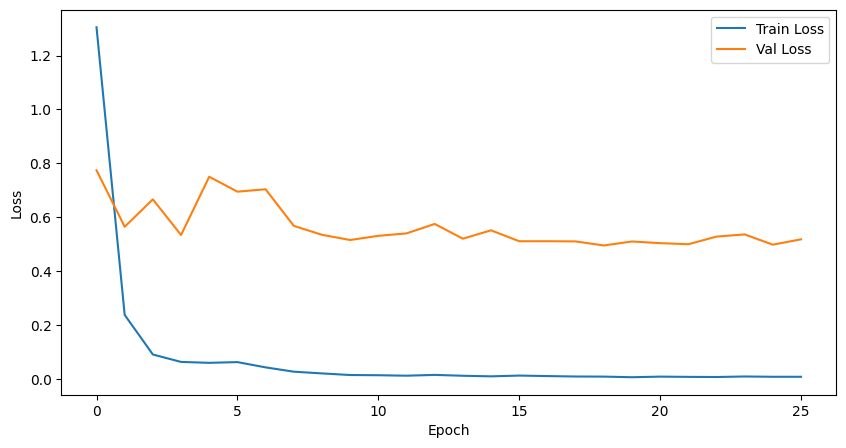

In [55]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

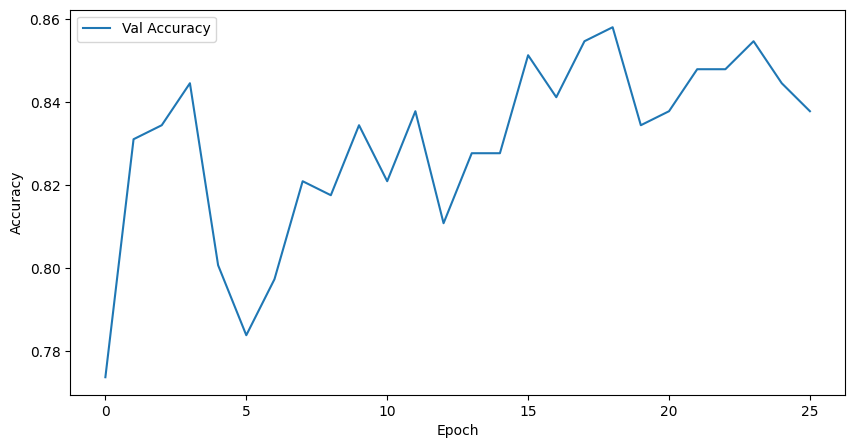

In [56]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [57]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [58]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 16
num_epochs = 30
patience = 7

In [59]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [60]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler)

Epoch [1/30], Train Loss: 1.3319 Acc: 0.6970 | Val Loss: 0.8746 Acc: 0.7568
Epoch [2/30], Train Loss: 0.2130 Acc: 0.9754 | Val Loss: 0.6627 Acc: 0.8007
Epoch [3/30], Train Loss: 0.0652 Acc: 0.9962 | Val Loss: 0.5634 Acc: 0.8142
Epoch [4/30], Train Loss: 0.0356 Acc: 0.9985 | Val Loss: 0.6377 Acc: 0.8007
Epoch [5/30], Train Loss: 0.0396 Acc: 0.9951 | Val Loss: 0.6090 Acc: 0.8277
Epoch [6/30], Train Loss: 0.0186 Acc: 1.0000 | Val Loss: 0.5268 Acc: 0.8277
Epoch [7/30], Train Loss: 0.0125 Acc: 0.9996 | Val Loss: 0.5372 Acc: 0.8514
Epoch [8/30], Train Loss: 0.0091 Acc: 1.0000 | Val Loss: 0.5193 Acc: 0.8378
Epoch [9/30], Train Loss: 0.0076 Acc: 1.0000 | Val Loss: 0.4886 Acc: 0.8547
Epoch [10/30], Train Loss: 0.0070 Acc: 1.0000 | Val Loss: 0.4717 Acc: 0.8480
Epoch [11/30], Train Loss: 0.0086 Acc: 1.0000 | Val Loss: 0.5320 Acc: 0.8480
Epoch [12/30], Train Loss: 0.0076 Acc: 1.0000 | Val Loss: 0.5578 Acc: 0.8345
Epoch [13/30], Train Loss: 0.0068 Acc: 1.0000 | Val Loss: 0.5393 Acc: 0.8412
Epoch [1

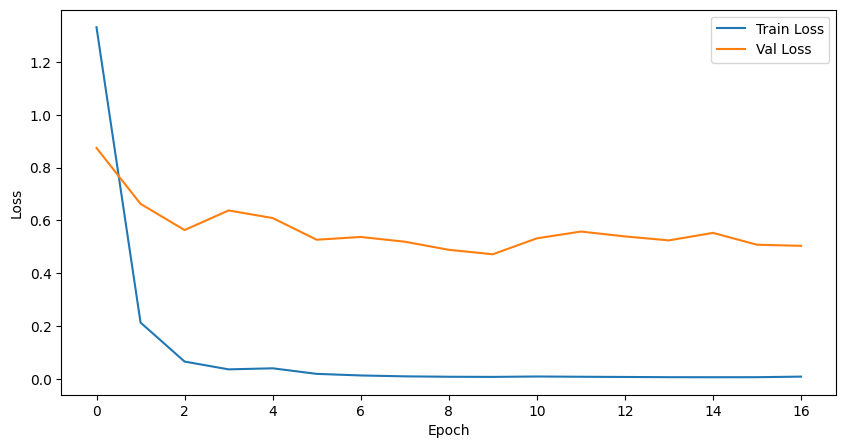

In [61]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

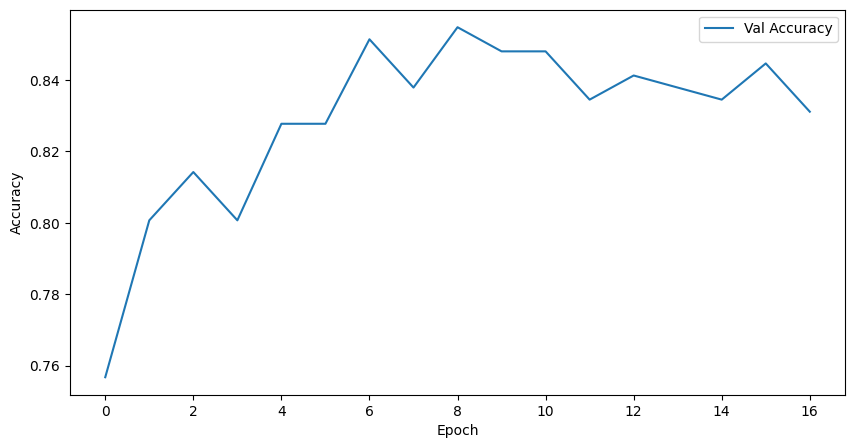

In [62]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [64]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [65]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 64
num_epochs = 30
patience = 7

In [9]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [67]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler)

Epoch [1/30], Train Loss: 1.8371 Acc: 0.5769 | Val Loss: 1.3920 Acc: 0.6149
Epoch [2/30], Train Loss: 0.3746 Acc: 0.9580 | Val Loss: 0.8631 Acc: 0.8041
Epoch [3/30], Train Loss: 0.1114 Acc: 0.9962 | Val Loss: 0.7603 Acc: 0.7804
Epoch [4/30], Train Loss: 0.0457 Acc: 1.0000 | Val Loss: 0.6577 Acc: 0.8209
Epoch [5/30], Train Loss: 0.0261 Acc: 0.9996 | Val Loss: 0.6808 Acc: 0.8142
Epoch [6/30], Train Loss: 0.0223 Acc: 0.9996 | Val Loss: 0.6804 Acc: 0.7939
Epoch [7/30], Train Loss: 0.0148 Acc: 1.0000 | Val Loss: 0.5850 Acc: 0.8142
Epoch [8/30], Train Loss: 0.0116 Acc: 1.0000 | Val Loss: 0.6022 Acc: 0.8108
Epoch [9/30], Train Loss: 0.0107 Acc: 1.0000 | Val Loss: 0.5873 Acc: 0.8108
Epoch [10/30], Train Loss: 0.0095 Acc: 1.0000 | Val Loss: 0.5790 Acc: 0.8142
Epoch [11/30], Train Loss: 0.0101 Acc: 1.0000 | Val Loss: 0.5724 Acc: 0.8142
Epoch [12/30], Train Loss: 0.0094 Acc: 1.0000 | Val Loss: 0.6168 Acc: 0.8007
Epoch [13/30], Train Loss: 0.0093 Acc: 1.0000 | Val Loss: 0.5756 Acc: 0.8243
Epoch [1

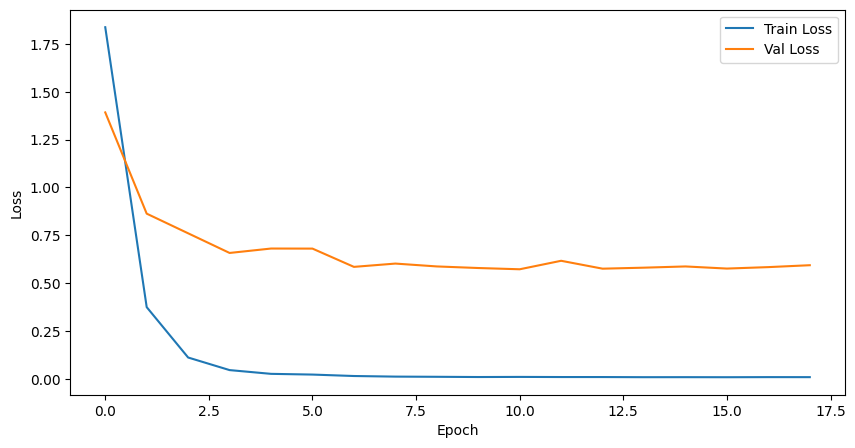

In [68]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

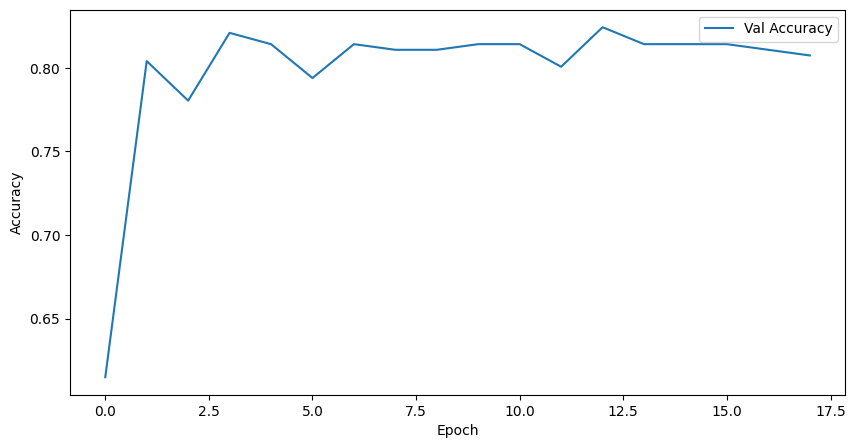

In [69]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### EXPERIMENT 6 - OPTIMIZATION OF PATIENCE HYPERPARAMETER

In this experiment, different choices for patience are compared; the original setup is otherwise left as it is.

In [ ]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [8]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 32
num_epochs = 30
patience = 3

In [12]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler)

Epoch [1/30], Train Loss: 1.5420 Acc: 0.6485 | Val Loss: 1.1047 Acc: 0.7500
Epoch [2/30], Train Loss: 0.2532 Acc: 0.9727 | Val Loss: 0.7378 Acc: 0.8311
Epoch [3/30], Train Loss: 0.0793 Acc: 0.9951 | Val Loss: 0.7040 Acc: 0.8345
Epoch [4/30], Train Loss: 0.0350 Acc: 0.9996 | Val Loss: 0.6323 Acc: 0.8243
Epoch [5/30], Train Loss: 0.0176 Acc: 1.0000 | Val Loss: 0.5775 Acc: 0.8412
Epoch [6/30], Train Loss: 0.0142 Acc: 0.9989 | Val Loss: 0.5615 Acc: 0.8581
Epoch [7/30], Train Loss: 0.0101 Acc: 1.0000 | Val Loss: 0.5577 Acc: 0.8480
Epoch [8/30], Train Loss: 0.0084 Acc: 1.0000 | Val Loss: 0.5718 Acc: 0.8345
Epoch [9/30], Train Loss: 0.0081 Acc: 1.0000 | Val Loss: 0.5666 Acc: 0.8615
Epoch [10/30], Train Loss: 0.0078 Acc: 1.0000 | Val Loss: 0.5508 Acc: 0.8716
Epoch [11/30], Train Loss: 0.0077 Acc: 1.0000 | Val Loss: 0.5644 Acc: 0.8446
Epoch [12/30], Train Loss: 0.0070 Acc: 1.0000 | Val Loss: 0.5807 Acc: 0.8277
Epoch [13/30], Train Loss: 0.0071 Acc: 1.0000 | Val Loss: 0.5615 Acc: 0.8581
Early st

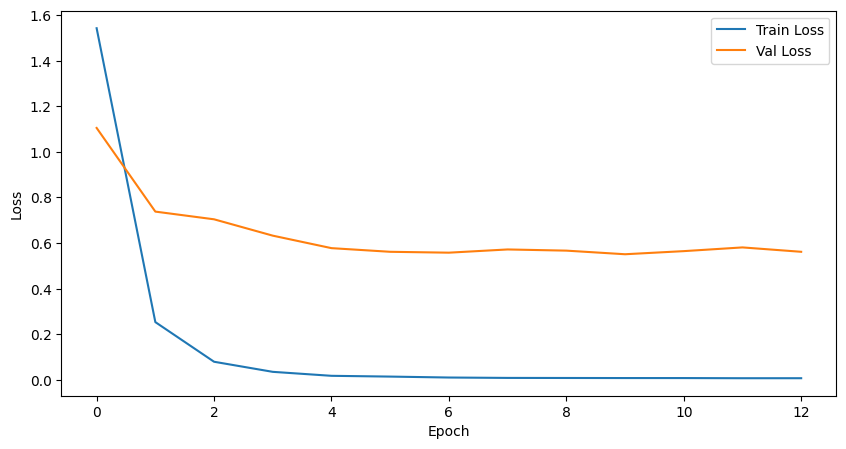

In [13]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

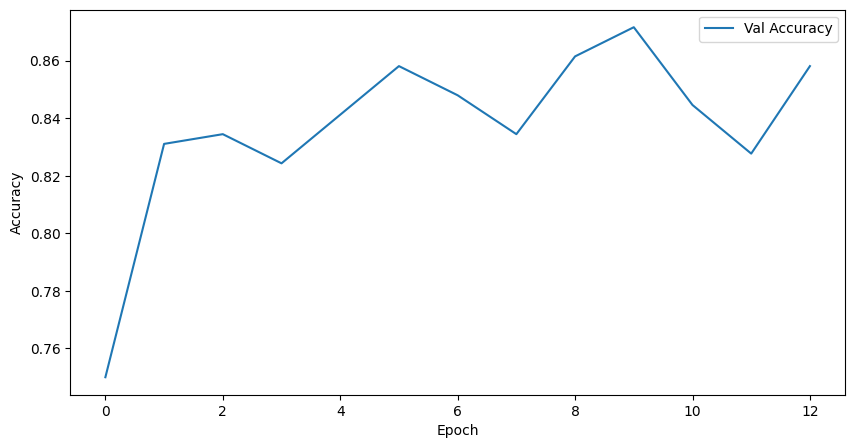

In [14]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [18]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 32
num_epochs = 30
patience = 5

In [19]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler)

Epoch [1/30], Train Loss: 1.5582 Acc: 0.6420 | Val Loss: 1.1049 Acc: 0.6892
Epoch [2/30], Train Loss: 0.2513 Acc: 0.9780 | Val Loss: 0.7736 Acc: 0.7736
Epoch [3/30], Train Loss: 0.0697 Acc: 0.9985 | Val Loss: 0.6997 Acc: 0.7939
Epoch [4/30], Train Loss: 0.0342 Acc: 0.9981 | Val Loss: 0.6853 Acc: 0.8108
Epoch [5/30], Train Loss: 0.0219 Acc: 0.9992 | Val Loss: 0.5675 Acc: 0.8412
Epoch [6/30], Train Loss: 0.0127 Acc: 1.0000 | Val Loss: 0.5575 Acc: 0.8412
Epoch [7/30], Train Loss: 0.0094 Acc: 1.0000 | Val Loss: 0.5268 Acc: 0.8480
Epoch [8/30], Train Loss: 0.0077 Acc: 1.0000 | Val Loss: 0.5439 Acc: 0.8378
Epoch [9/30], Train Loss: 0.0072 Acc: 1.0000 | Val Loss: 0.5408 Acc: 0.8412
Epoch [10/30], Train Loss: 0.0070 Acc: 1.0000 | Val Loss: 0.5305 Acc: 0.8446
Epoch [11/30], Train Loss: 0.0070 Acc: 1.0000 | Val Loss: 0.5303 Acc: 0.8480
Epoch [12/30], Train Loss: 0.0069 Acc: 1.0000 | Val Loss: 0.5398 Acc: 0.8446
Early stopping triggered
Minimum val loss: 0.5268


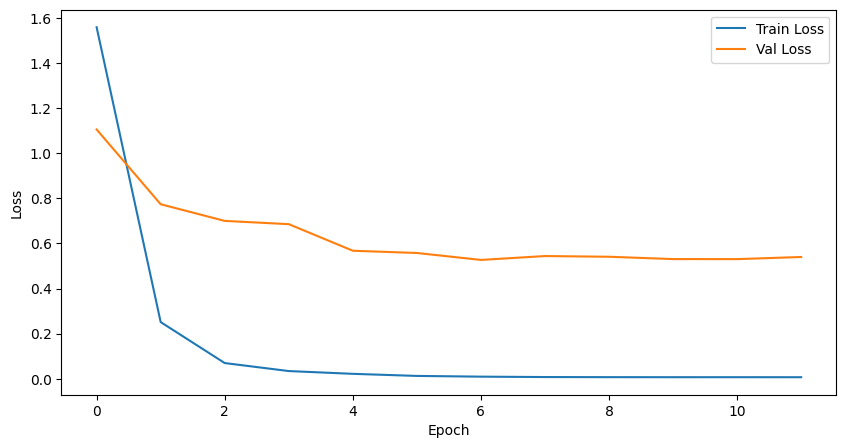

In [20]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

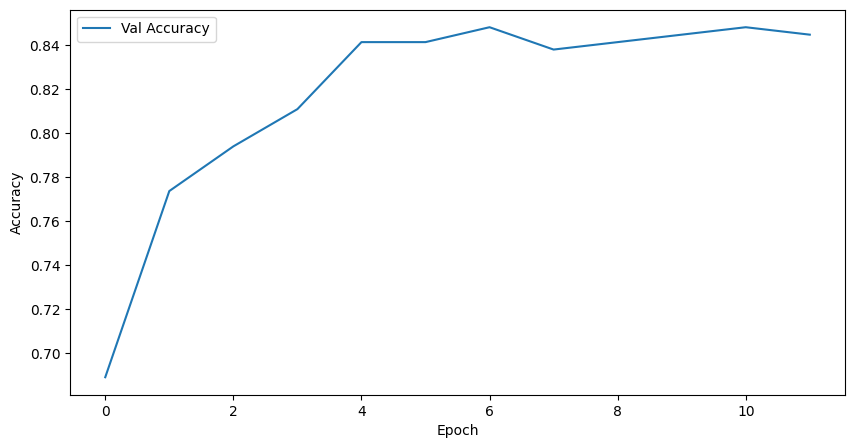

In [21]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [23]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 32
num_epochs = 30
patience = 10

In [24]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler)

Epoch [1/30], Train Loss: 1.4941 Acc: 0.6712 | Val Loss: 1.0925 Acc: 0.6757
Epoch [2/30], Train Loss: 0.2208 Acc: 0.9811 | Val Loss: 0.7438 Acc: 0.8007
Epoch [3/30], Train Loss: 0.0676 Acc: 0.9989 | Val Loss: 0.6746 Acc: 0.8142
Epoch [4/30], Train Loss: 0.0330 Acc: 0.9985 | Val Loss: 0.7900 Acc: 0.7973
Epoch [5/30], Train Loss: 0.0376 Acc: 0.9962 | Val Loss: 0.6349 Acc: 0.8108
Epoch [6/30], Train Loss: 0.0123 Acc: 1.0000 | Val Loss: 0.5637 Acc: 0.8277
Epoch [7/30], Train Loss: 0.0095 Acc: 1.0000 | Val Loss: 0.5473 Acc: 0.8378
Epoch [8/30], Train Loss: 0.0081 Acc: 1.0000 | Val Loss: 0.5806 Acc: 0.8142
Epoch [9/30], Train Loss: 0.0072 Acc: 1.0000 | Val Loss: 0.5718 Acc: 0.8108
Epoch [10/30], Train Loss: 0.0071 Acc: 1.0000 | Val Loss: 0.5586 Acc: 0.8345
Epoch [11/30], Train Loss: 0.0068 Acc: 1.0000 | Val Loss: 0.5546 Acc: 0.8378
Epoch [12/30], Train Loss: 0.0078 Acc: 1.0000 | Val Loss: 0.5371 Acc: 0.8345
Epoch [13/30], Train Loss: 0.0073 Acc: 1.0000 | Val Loss: 0.5510 Acc: 0.8311
Epoch [1

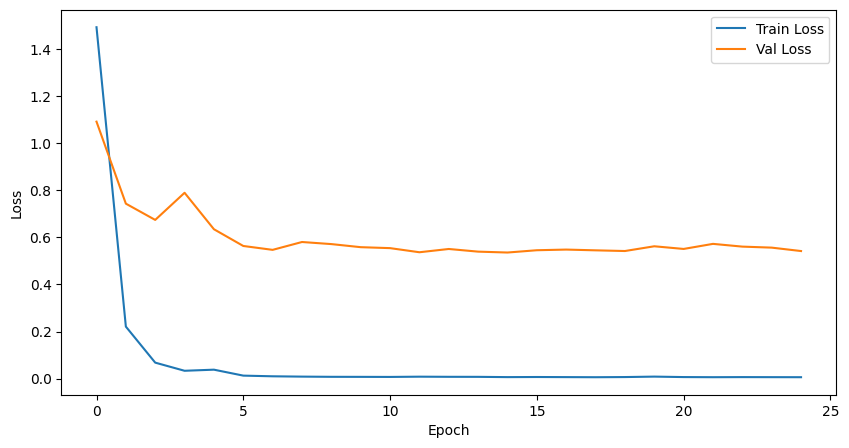

In [26]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

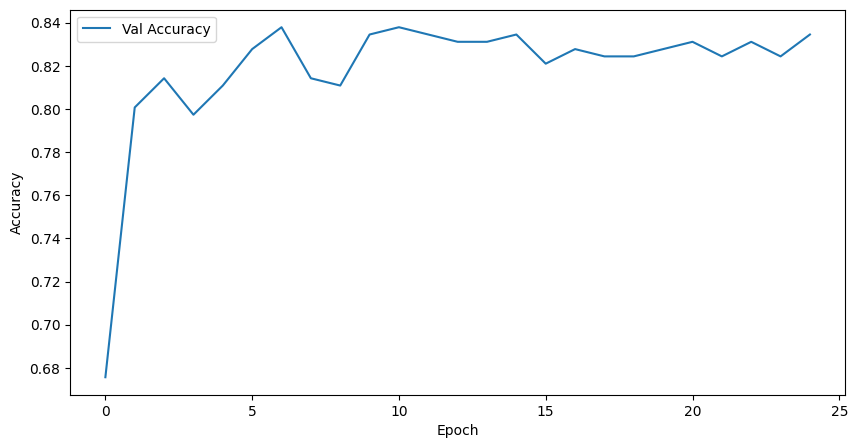

In [27]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [32]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 32
num_epochs = 30
patience = 30

In [33]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler)

Epoch [1/30], Train Loss: 1.5078 Acc: 0.6614 | Val Loss: 1.0319 Acc: 0.7230
Epoch [2/30], Train Loss: 0.2363 Acc: 0.9750 | Val Loss: 0.7176 Acc: 0.7973
Epoch [3/30], Train Loss: 0.0698 Acc: 0.9989 | Val Loss: 0.6725 Acc: 0.8108
Epoch [4/30], Train Loss: 0.0321 Acc: 1.0000 | Val Loss: 0.6321 Acc: 0.8108
Epoch [5/30], Train Loss: 0.0196 Acc: 0.9992 | Val Loss: 0.7027 Acc: 0.8074
Epoch [6/30], Train Loss: 0.0171 Acc: 0.9989 | Val Loss: 0.6882 Acc: 0.8074
Epoch [7/30], Train Loss: 0.0135 Acc: 0.9992 | Val Loss: 0.6760 Acc: 0.8209
Epoch [8/30], Train Loss: 0.0108 Acc: 0.9992 | Val Loss: 0.5922 Acc: 0.8142
Epoch [9/30], Train Loss: 0.0085 Acc: 1.0000 | Val Loss: 0.5967 Acc: 0.8243
Epoch [10/30], Train Loss: 0.0077 Acc: 1.0000 | Val Loss: 0.5780 Acc: 0.8176
Epoch [11/30], Train Loss: 0.0078 Acc: 1.0000 | Val Loss: 0.5907 Acc: 0.8142
Epoch [12/30], Train Loss: 0.0074 Acc: 1.0000 | Val Loss: 0.5900 Acc: 0.8108
Epoch [13/30], Train Loss: 0.0071 Acc: 1.0000 | Val Loss: 0.5508 Acc: 0.8277
Epoch [1

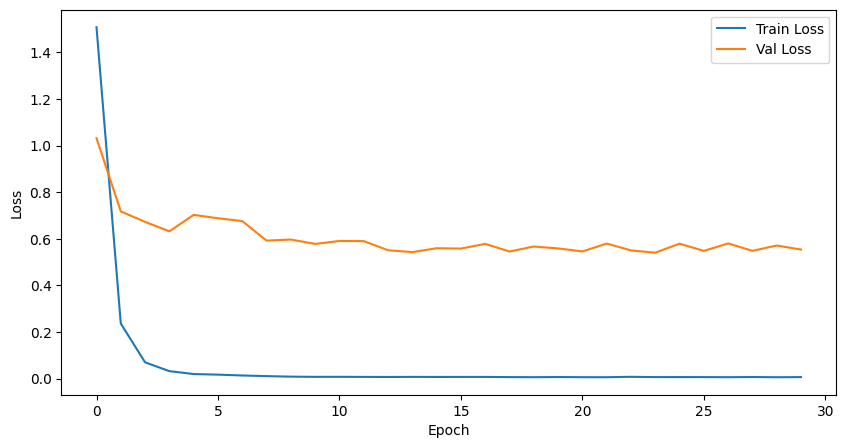

In [34]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

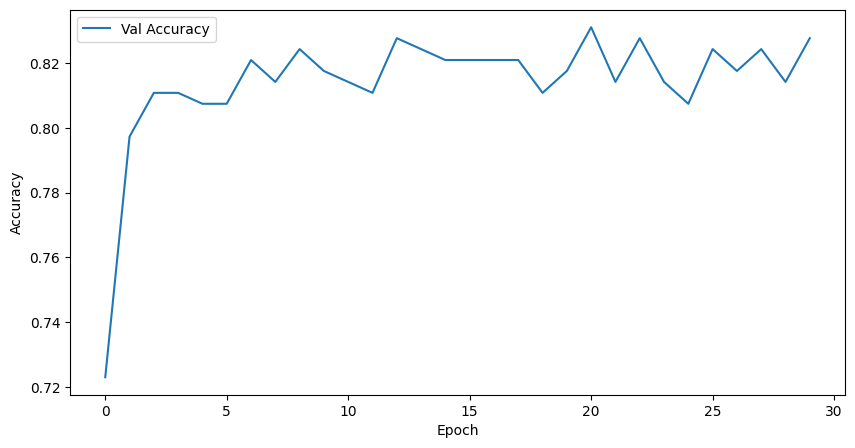

In [35]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### EXPERIMENT 7 - OPTIMIZATION OF NUMBER OF EPOCHS

This experiment explores the impact of varying the number of training epochs on the validation accuracy. In order to correctly evaluate the experiments, the patience value is set as equal to the number of epochs.

In [36]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [37]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 32
num_epochs = 40
patience = 40

In [38]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler)

Epoch [1/40], Train Loss: 1.5069 Acc: 0.6564 | Val Loss: 1.0899 Acc: 0.7230
Epoch [2/40], Train Loss: 0.2375 Acc: 0.9750 | Val Loss: 0.7451 Acc: 0.8041
Epoch [3/40], Train Loss: 0.0781 Acc: 0.9970 | Val Loss: 0.6566 Acc: 0.8108
Epoch [4/40], Train Loss: 0.0343 Acc: 0.9992 | Val Loss: 0.5593 Acc: 0.8277
Epoch [5/40], Train Loss: 0.0200 Acc: 1.0000 | Val Loss: 0.5769 Acc: 0.8176
Epoch [6/40], Train Loss: 0.0145 Acc: 0.9996 | Val Loss: 0.5412 Acc: 0.8176
Epoch [7/40], Train Loss: 0.0098 Acc: 1.0000 | Val Loss: 0.5212 Acc: 0.8209
Epoch [8/40], Train Loss: 0.0075 Acc: 1.0000 | Val Loss: 0.5062 Acc: 0.8277
Epoch [9/40], Train Loss: 0.0077 Acc: 1.0000 | Val Loss: 0.5299 Acc: 0.8277
Epoch [10/40], Train Loss: 0.0081 Acc: 1.0000 | Val Loss: 0.5286 Acc: 0.8209
Epoch [11/40], Train Loss: 0.0076 Acc: 1.0000 | Val Loss: 0.5346 Acc: 0.8142
Epoch [12/40], Train Loss: 0.0066 Acc: 1.0000 | Val Loss: 0.5326 Acc: 0.8108
Epoch [13/40], Train Loss: 0.0062 Acc: 1.0000 | Val Loss: 0.5632 Acc: 0.8074
Epoch [1

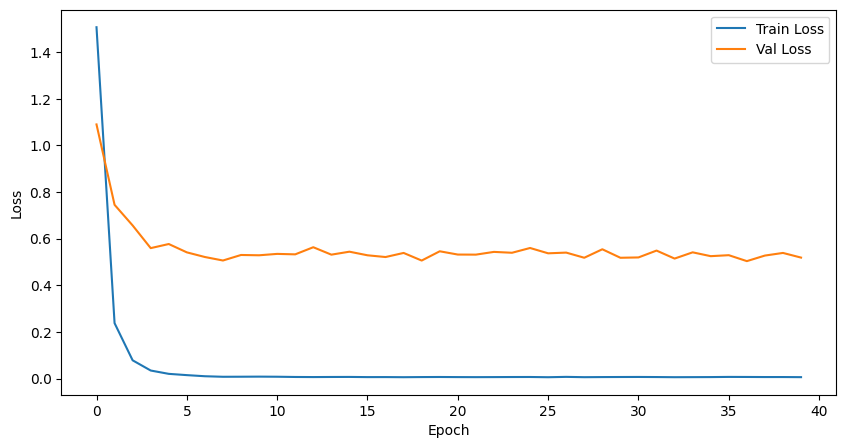

In [39]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

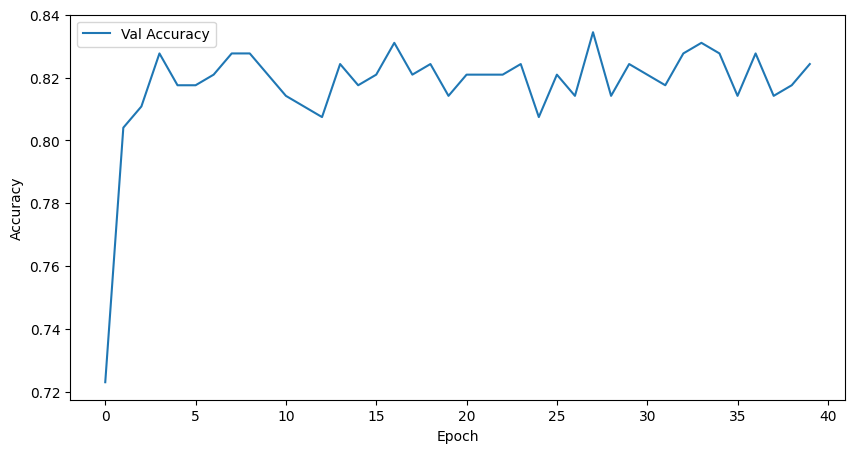

In [40]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [41]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [42]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 32
num_epochs = 50
patience = 50

In [43]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler)

Epoch [1/50], Train Loss: 1.4793 Acc: 0.6629 | Val Loss: 1.0061 Acc: 0.7635
Epoch [2/50], Train Loss: 0.2323 Acc: 0.9784 | Val Loss: 0.6803 Acc: 0.8108
Epoch [3/50], Train Loss: 0.0604 Acc: 1.0000 | Val Loss: 0.6159 Acc: 0.8243
Epoch [4/50], Train Loss: 0.0319 Acc: 0.9985 | Val Loss: 0.5598 Acc: 0.8412
Epoch [5/50], Train Loss: 0.0236 Acc: 0.9996 | Val Loss: 0.6065 Acc: 0.8345
Epoch [6/50], Train Loss: 0.0161 Acc: 0.9992 | Val Loss: 0.5794 Acc: 0.8446
Epoch [7/50], Train Loss: 0.0128 Acc: 0.9996 | Val Loss: 0.5406 Acc: 0.8446
Epoch [8/50], Train Loss: 0.0094 Acc: 0.9996 | Val Loss: 0.5182 Acc: 0.8615
Epoch [9/50], Train Loss: 0.0079 Acc: 1.0000 | Val Loss: 0.5173 Acc: 0.8514
Epoch [10/50], Train Loss: 0.0077 Acc: 1.0000 | Val Loss: 0.5198 Acc: 0.8412
Epoch [11/50], Train Loss: 0.0068 Acc: 1.0000 | Val Loss: 0.5081 Acc: 0.8547
Epoch [12/50], Train Loss: 0.0073 Acc: 0.9996 | Val Loss: 0.5163 Acc: 0.8514
Epoch [13/50], Train Loss: 0.0064 Acc: 1.0000 | Val Loss: 0.4984 Acc: 0.8649
Epoch [1

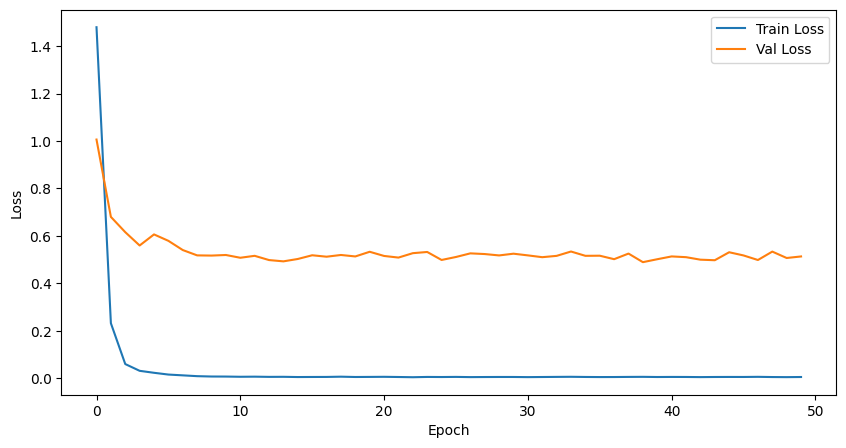

In [44]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

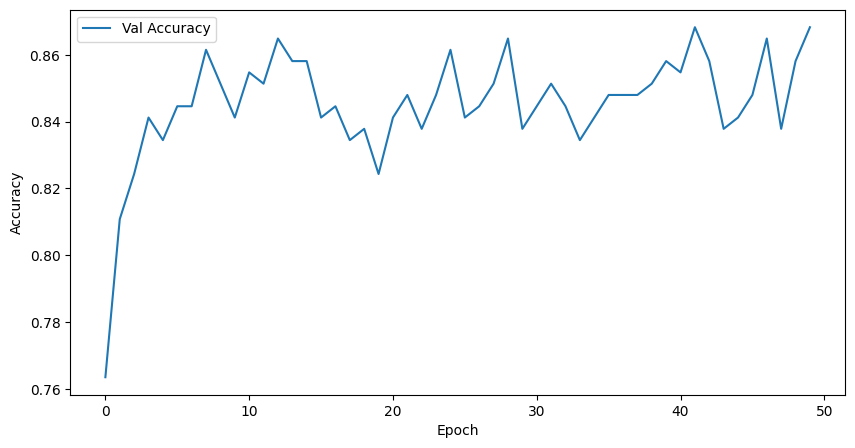

In [45]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [46]:
model = models.resnet18(weights='IMAGENET1K_V1')

# The final layer is modified to have 43 classes as output
num_classes = 43
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

In [47]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

# learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

batch_size = 32
num_epochs = 100
patience = 100

In [48]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler)

Epoch [1/100], Train Loss: 1.5171 Acc: 0.6447 | Val Loss: 1.0179 Acc: 0.7534
Epoch [2/100], Train Loss: 0.2436 Acc: 0.9803 | Val Loss: 0.7349 Acc: 0.8277
Epoch [3/100], Train Loss: 0.0707 Acc: 0.9977 | Val Loss: 0.6381 Acc: 0.8480
Epoch [4/100], Train Loss: 0.0311 Acc: 0.9992 | Val Loss: 0.5374 Acc: 0.8547
Epoch [5/100], Train Loss: 0.0209 Acc: 1.0000 | Val Loss: 0.5406 Acc: 0.8615
Epoch [6/100], Train Loss: 0.0154 Acc: 1.0000 | Val Loss: 0.6360 Acc: 0.8311
Epoch [7/100], Train Loss: 0.0216 Acc: 0.9966 | Val Loss: 0.6131 Acc: 0.8446
Epoch [8/100], Train Loss: 0.0112 Acc: 0.9996 | Val Loss: 0.5857 Acc: 0.8514
Epoch [9/100], Train Loss: 0.0096 Acc: 1.0000 | Val Loss: 0.5673 Acc: 0.8514
Epoch [10/100], Train Loss: 0.0086 Acc: 1.0000 | Val Loss: 0.5750 Acc: 0.8581
Epoch [11/100], Train Loss: 0.0083 Acc: 1.0000 | Val Loss: 0.5412 Acc: 0.8649
Epoch [12/100], Train Loss: 0.0089 Acc: 1.0000 | Val Loss: 0.5401 Acc: 0.8649
Epoch [13/100], Train Loss: 0.0074 Acc: 1.0000 | Val Loss: 0.5646 Acc: 0.

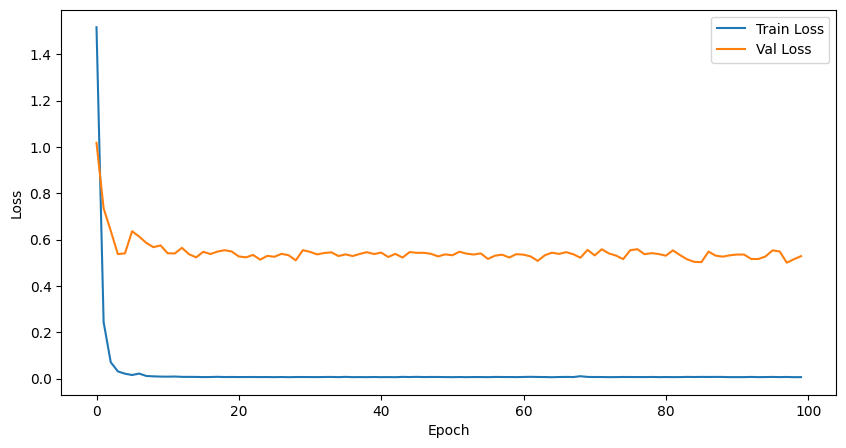

In [49]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

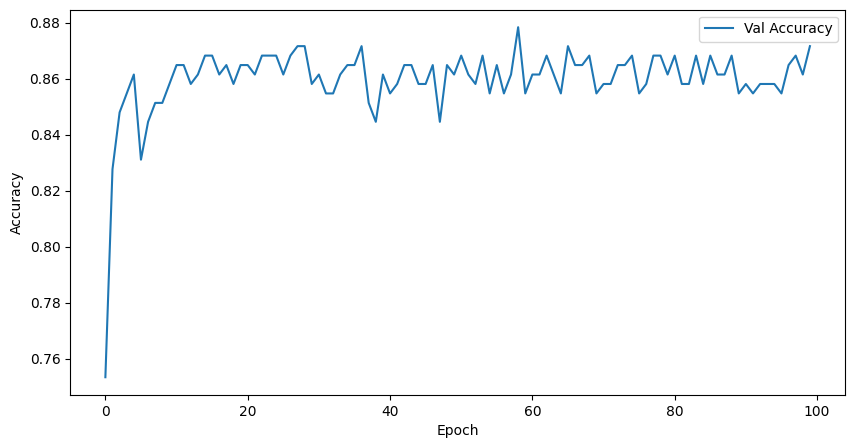

In [50]:
# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

ALTRE COSE DA FARE: 

1. Converti tutti i processi in funzioni IN UN NUOVO NOTEBOOK, NON SOVRASCRIVERE QUESTO
2. Risolvi problema ripetibilità (setta un seme usando il codice nella prossima cella e rirunna tutto il notebook FACENDONE UNO NUOVO -> solo dopo aver convertito tutto in funzioni, per runnare una sola volta!)
3. Markdown appropriati ed esplicativi del processo mentale
4. Elimina commenti inutili

In [ ]:
# Set seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(123) 